# Imports

In [51]:
# General includes.
import os
import io
import re
import errno
import gc
import random
import threading
import math
import itertools
import functools
from copy import deepcopy
import logging
import pickle
import tqdm
import hashlib

#from termcolor import colored, cprint
import colored
from datetime import datetime, timedelta
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from matplotlib import pyplot as plt

# Typing includes.
from typing import Dict, List, Optional, Any, Tuple, Callable, Iterable

# Numerical includes.
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, auc
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve, precision_recall_curve
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# pyHealth includes.
from pyhealth.datasets import BaseDataset, MIMIC3Dataset, eICUDataset, SampleDataset, split_by_patient
from pyhealth.datasets.utils import MODULE_CACHE_PATH, strptime, hash_str
from pyhealth.data import Patient, Visit, Event

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [52]:
# Model imports 
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, BertTokenizerFast
from transformers import TensorType
from transformers import AutoTokenizer, AutoConfig, AutoModel

In [53]:
# Local imports
from tasks.code_emb_funcs import *
from tasks.desc_emb_funcs import *
from tasks.eicu_funcs import *
from tasks.dataset_transforms import *
from tasks.collate_funcs import *
# from tasks import code_emb_funcs, desc_emb_funcs, eicu_funcs
# from tasks import dataset_transforms, collate_funcs
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

In [19]:
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Globals

In [20]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
USE_GPU_ = False
BERT_USE_GPU_ = True  # BERT embeddings 
DEV_ = True  # Uses a small subset of MIMIC data: https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html#pyhealth.datasets.MIMIC3Dataset
GPU_STR_ = 'cuda'
# DATA_DIR_ = os.path.join(os.getcwd(), DATA_DIR_)
MIMIC_DATA_DIR_ = '~/sw/physionet.org/files/mimiciii/1.4'
EICU_DATA_DIR_ = '~/sw/eicu-collaborative-research-database-2.0/eicu-collaborative-research-database-2.0'
BATCH_SIZE_ = 32
EMBEDDING_DIM_ = 264  # BERT requires a multiple of 12
SHUFFLE_ = True
SAMPLE_MULTIPLIER_ = 1

# Set seed for reproducibility.
seed = 90210
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


def save_pickle(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)
        
# https://stackoverflow.com/questions/50888391/pickle-of-object-with-getattr-method-in-python-returns-typeerror-object-no
class DotArgs(dict):
    """
    Access dictionary attributes via dot notation
    """
    def __getstate__(self):
        return vars(self)

    def __setstate__(self, state):
        vars(self).update(state)
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


# Reproducability Summary

#### Description

This notebook attempts to replicate the paper Unifying Heterogeneous Electronic Health Records Systems via Text-Based Code Embedding. It processes the eICU and MIMIC-III databases into an embedding using either a Text Encoder model or a RNN trained on sequences of medical events. The Text Encoder model is swappable, in practice we use BERT and BERT-Tiny. A Bidirectional-RNN using GRUs is then trained to make medical outcome predictions (e.g. Mortality) using the Medical Code or Medical Text embeddings from the Encoder layer as input. The .ipynb contains code to train, evaluate and plot performance of both models.

#### Execution Instructions.

Run the notebook starting from top. Replace the following two globals with the correct path to the MIMIC-III and eICU datasets in your environment.

```
MIMIC_DATA_DIR_ = '~/sw/physionet.org/files/mimiciii/1.4'
EICU_DATA_DIR_ = '~/sw/eicu-collaborative-research-database-2.0/eicu-collaborative-research-database-2.0'
```

#### Results Summary

See the section **Condensed Training using Trainer** for details and plots of each model. Note the second section for eICU at the end of the notebook.

**Claim 1**

Claim 1: The prediction performance of Description-based Embedding (DescEmb) will be equal or better to Code-based Embedding (CodeEmb) while also allowing for greater flexibility by being able to work on EHR datasets with different formats. We will test this by creating both CodeEmb and DescEmb implementations and testing and comparing their performance.

**Outcome**: Reproducible

|               | **Mortablity<br>CodeEmb**     | **Mortality<br>DescEmb**     | **Readmission<br> CodeEmb**   | **Readmission DescEmb**      |
|---------------|-------------------------------|------------------------------|-------------------------------|------------------------------|
| **AUPRC**     | 0.61<br>(4681/28745 = 16% TP) | 0.7<br>(1519/11835 = 12% TP) | 0.84<br>(6529/26897 = 24% TP) | 0.86<br>(3363/9991 = 33% TP) |
| **AUROC**     | 0.88                          | 0.92                         | 0.89                          | 0.91                         |
| **Accuracy**  | 0.89                          | 0.91                         | 0.94                          | 0.94                         |
| **Precision** | 0.66                          | 0.76                         | 0.99                          | 0.86                         |
| **Recall**    | 0.47                          | 0.37                         | 0.72                          | 0.78                         |

<br>
<br>

**Claim 2**

Claim 2: Two differently structured EHRs can be used to train and test predictive models interchangeably. We will use two different datasets (MIMIC-III, eICU) with different formatting to train an RNN and compare their performance

**Outcome**: Not Reproducible

| **null**     | **DescEmb MIMIC-III**    | **DescEmb eICU**           |
|--------------|--------------------------|----------------------------|
| **AUPRC**    | 0.7 (1519/11835= 12% TP) | 0.2 (1266/15117 = 8.3% TP) |
| **AUROC**    | 0.92                     | 0.75                       |
| **Accuracy** | 0.88                     | 0.92                       |


<br>
<br>

**Claim 3**

Claim 3: The original authors used two variants of the BERT text encoder. They named the variants CLS-FT and FT. The CLS-FT model a pretrained BERT (e.g. ‘bert-uncased’) with frozen weights. The FT model uses a pre-trained BERT, but fine-tunes the model weights by updating them during training via backprop. Table 2 in the original paper shows that CLS-FT and FT had approximately equal accuracy with CLS-FT requiring far less compute to train. 

**Outcome**: Partially Reproducible

|               | **Mortality CodeEmb**         | **Mortality DescEmb**        | **Mortality DescEmbFt**       |
|---------------|-------------------------------|------------------------------|-------------------------------|
| **AUPRC**     | 0.61<br>(4681/28745 = 16% TP) | 0.7<br>(1519/11835 = 12% TP) | 0.45<br>(1519/11835 = 12% TP) |
| **AUROC**     | 0.88                          | 0.92                         | 0.84                          |
| **Accuracy**  | 0.89                          | 0.91                         | 0.87                          |
| **Precision** | 0.66                          | 0.76                         | 0.54                          |
| **Recall**    | 0.47                          | 0.37                         | 0.19                          |


# Citations


```
@misc{hur2022unifying,
      title={Unifying Heterogeneous Electronic Health Records Systems via Text-Based Code Embedding}, 
      author={Kyunghoon Hur and Jiyoung Lee and Jungwoo Oh and Wesley Price and Young-Hak Kim and Edward Choi},
      year={2022},
      eprint={2108.03625},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}
```

```
@misc{zhao2021pyhealth,
      title={PyHealth: A Python Library for Health Predictive Models}, 
      author={Yue Zhao and Zhi Qiao and Cao Xiao and Lucas Glass and Jimeng Sun},
      year={2021},
      eprint={2101.04209},
      archivePrefix={arXiv},
      primaryClass={cs.LG}
}
```

```
@inproceedings{devlin-etal-2019-bert,
    title = "{BERT}: Pre-training of Deep Bidirectional Transformers for Language Understanding",
    author = "Devlin, Jacob  and
      Chang, Ming-Wei  and
      Lee, Kenton  and
      Toutanova, Kristina",
    booktitle = "Proceedings of the 2019 Conference of the North {A}merican Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers)",
    month = jun,
    year = "2019",
    address = "Minneapolis, Minnesota",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/N19-1423",
    doi = "10.18653/v1/N19-1423",
    pages = "4171--4186",
}
```

```
Johnson, A., Pollard, T., & Mark, R. (2016).
MIMIC-III Clinical Database (version 1.4).
PhysioNet. https://doi.org/10.13026/C2XW26.
```

```
Johnson, A., Pollard, T., Shen, L. et al. MIMIC-III, a freely accessible critical care database.
Sci Data 3, 160035 (2016). https://doi.org/10.1038/sdata.2016.35
```

# Preprocessing

### Load MIMIC III Data

In [21]:
if False:
    from pyhealth.medcode import InnerMap, ICD9CM

    icd9cm = InnerMap.load("ICD9CM")
    icd9cm.lookup("428.0") # get detailed info
    icd9cm.get_ancestors("428.0") # get parents

    print(icd9cm.lookup("78951")) # get detailed info
    print(f'78951 ancestors {icd9cm.get_ancestors("78951")}') # get parents

    print(icd9cm.lookup("7895")) # get detailed info
    print(f'7895 ancestors {icd9cm.get_ancestors("7895")}') # get parents


    print(icd9cm.lookup("7894")) # get detailed info
    print(f'7894 ancestors {icd9cm.get_ancestors("7894")}') # get parents

    print(icd9cm.lookup("78942")) # get detailed info
    print(f'78941 ancestors {icd9cm.get_ancestors("78941")}') # get parents

    print(ICD9CM.standardize('78951'))
    print(ICD9CM.standardize('7895'))

In [22]:
def _compute_duration_minutes(start_datetime: str, end_datetime: str) -> float:
    '''Return duration in minutes as a float.
    '''
    # MIMIC-III uses the following format: 2146-07-22 00:00:00
    start = datetime.strptime(start_datetime, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_datetime,   '%Y-%m-%d %H:%M:%S')
    return float((end - start).seconds)

class MIMIC3DatasetWrapper(MIMIC3Dataset):
    ''' Add extra tables to the MIMIC III dataset.
    
      Some of the tables we need like "D_ICD_DIAGNOSES", "D_ITEMS", "D_ICD_PROCEDURES"
      are not supported out of the box. 
      
      This class defines parsing methods to extract text data from these extra tables.
      The text data is generally joined on the PATIENTID, HADMID, ITEMID to match the
      pyHealth Vists class representation.
    '''
   
    # We need to add storage for text-based lookup tables here.
    def __init__(self, *args, **kwargs):
        self._valid_text_tables = ["D_ICD_DIAGNOSES", "D_ITEMS", "D_ICD_PROCEDURES", "D_LABITEMS"]
        self._text_descriptions = {x: {} for x in self._valid_text_tables}
        self._text_luts = {x: {} for x in self._valid_text_tables}
        self.refresh_cache = False
        # The pyHealth dataset cache doesn't know about this class's private members.
        if 'refresh_cache' in kwargs:
            self.refresh_cache = kwargs['refresh_cache']
        super().__init__(*args, **kwargs)
        self._do_cache()
    
    def _do_cache(self):
        '''The pyHealth dataset cache doesn't know about this classes private members.
        
          We need to wrap the caching function so it's aware of the additional luts
          to be saved/restored. The superclass is still responsible for saving/restoring
          `self.patients` from the DB.
        '''
        self.extra_filepath = ''.join([
            os.path.splitext(self.filepath)[0],
            '_dev' if self.dev else '',
            '_extras.pkl',
        ])
        
        # check if cache exists or refresh_cache is True
        if os.path.exists(self.extra_filepath) and (not self.refresh_cache):
            # load from cache
            logger.info(
                f"Loaded {self.dataset_name} base dataset from {self.extra_filepath}"
            )
            from_pickle = load_pickle(self.extra_filepath)
            self._valid_text_tables = from_pickle['_valid_text_tables']
            self._text_descriptions = from_pickle['_text_descriptions']
            self._text_luts = from_pickle['_text_luts']
        else:
            # load from raw data
            logger.info(f"Processing {self.dataset_name} base dataset...")
            to_cache = {
                '_valid_text_tables': self._valid_text_tables,
                '_text_descriptions': self._text_descriptions,
                '_text_luts': self._text_luts,
            }
            logger.info(f"Saved {self.dataset_name} base dataset to {self.extra_filepath}")
            save_pickle(to_cache, self.extra_filepath)
    
    def get_all_tables(self) -> List[str]: 
        return list(self._text_descriptions.keys())
        
    def get_text_dict(self, table_name: str) -> Dict[str, Dict[Any, Any]]:
        return self._text_descriptions.get(table_name)
    
    def set_text_lut(self, table_name: str, lut: Dict[Any, Any]) -> None:
        self._text_luts[table_name] = lut
    
    def get_text_lut(self, table_name: str) -> Dict[Any, Any]:
        return self._text_luts[table_name]
    
    def _add_events_to_patient_dict(
        self,
        patient_dict: Dict[str, Patient],
        group_df: pd.DataFrame,
    ) -> Dict[str, Patient]:
        #TODO(botelho3) Imported from PyHealth Base dataset githubf to
        #support parse_prescription
        """Helper function which adds the events column of a df.groupby object to the patient dict.
        
        Will be called at the end of each `self.parse_[table_name]()` function.
        Args:
            patient_dict: a dict mapping patient_id to `Patient` object.
            group_df: a df.groupby object, having two columns: patient_id and events.
                - the patient_id column is the index of the patient
                - the events column is a list of <Event> objects
        Returns:
            The updated patient dict.
        """
        for _, events in group_df.items():
            for event in events:
                patient_dict = self._add_event_to_patient_dict(patient_dict, event)
        return patient_dict

    
    def parse_prescriptions(self, patients: Dict[str, Patient]) -> Dict[str, Patient]:
        """Helper function which parses PRESCRIPTIONS table.
        
        TODO(botelho3) - we have to override this to include the text fields. The
        prescriptions table does not link to a separate D_ICD_* table in MIMIC-III
        thtat contains text descriptions of the prescription. The text descriptions
        are in the columns of this table. Regular pyHealth ignores these columns. We
        override this method to appent pyHealth Event objects containing the text
        columns to each patient.
        
        Will be called in `self.parse_tables()`
        Docs:
            - PRESCRIPTIONS: https://mimic.mit.edu/docs/iii/tables/prescriptions/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The updated patients dict.
        """
        table = "PRESCRIPTIONS"
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            low_memory=False,
            dtype={"SUBJECT_ID": str, "HADM_ID": str, "NDC": str,
                   "DRUG_TYPE": str, "DRUG": str,
                   "PROD_STRENGTH": str, "ROUTE": str, "ENDDATE": str},
        )
        # drop records of the other patients
        df = df[df["SUBJECT_ID"].isin(patients.keys())]
        df = df.dropna()
        # sort by start date and end date
        df = df.sort_values(
            ["SUBJECT_ID", "HADM_ID", "STARTDATE", "ENDDATE"], ascending=True
        )
        # group by patient and visit
        group_df = df.groupby("SUBJECT_ID")
        
        # parallel unit for prescription (per patient)
        def prescription_unit(p_id, p_info):
            events = []
            for v_id, v_info in p_info.groupby("HADM_ID"):
                zipped = zip(v_info["STARTDATE"], v_info["NDC"], v_info["DRUG_TYPE"],
                             v_info["DRUG"], v_info["PROD_STRENGTH"], v_info["ROUTE"],
                             v_info["ENDDATE"])
                for startdate, code, dtype, dname, dose, route, enddate in zipped:
                    if not type(startdate) == str:
                        startdate = '2142-07-18 00:00:00'
                    if not type(enddate) == str:
                        enddate = '2142-07-18 00:00:00'
                    assert(type(dname) is str)
                    # if not type(enddate) is str:
                    #     print(f'Not matching enddate {enddate} startdate {startdate}')
                    #     print(f'dname {dname}, hadm_id {v_id}, p_id {p_id}')
                    assert(type(startdate) is str)
                    assert(type(enddate) is str)
                    event = Event(
                        code=code,
                        table=table,
                        vocabulary="NDC",
                        visit_id=v_id,
                        patient_id=p_id,
                        timestamp=strptime(startdate),
                        dtype=dtype,
                        dname=dname,
                        dose=dose,
                        route=route,
                        duration=_compute_duration_minutes(startdate, enddate),
                    )
                    events.append(event)
            return events

                # parallel apply
        group_df = group_df.parallel_apply(
            lambda x: prescription_unit(x.SUBJECT_ID.unique()[0], x)
        )

        patients = self._add_events_to_patient_dict(patients, group_df)
        return patients
    
    # Note the name has to match the table name exactly.
    # See https://github.com/sunlabuiuc/PyHealth/blob/master/pyhealth/datasets/mimic3.py#L71.
    def parse_d_icd_diagnoses(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_ICD_DIAGNOSIS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_ICD_DIAGNOSIS: https://mimic.mit.edu/docs/iii/tables/d_icd_diagnoses/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ICD_DIAGNOSES.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text diagnosis description lookup
            for DescEmb.
        """
        table = "D_ICD_DIAGNOSES"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"],
            dtype={"ICD9_CODE": str, "SHORT_TITLE": str, "LONG_TITLE": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ICD9_CODE"], ascending=True)
       
        # print(df.head())
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    def parse_d_labitems(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_LABITEMS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_LABITEMS: https://mimic.mit.edu/docs/iii/tables/d_labitems/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_LABITEMS.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text lab measurement description lookup
            for DescEmb.
        """
        table = "D_LABITEMS"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ITEMID", "LABEL", "CATEGORY", "FLUID"],
            dtype={"ITEMID": str, "LABEL": str, "CATEGORY": str, "FLUID": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ITEMID", "LABEL", "CATEGORY", "FLUID"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ITEMID"], ascending=True)
       
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    
    def parse_d_items(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        # TODO(botelho3) - Note this may not be totally useable because the ITEMID
        # uinqiue key only links to these tables using ITEMID
        #   - INPUTEVENTS_MV 
        #   - OUTPUTEVENTS on ITEMID
        #   - PROCEDUREEVENTS_MV on ITEMID
        # 
        # Not to the tables we want e.g. 
        """Helper function which parses D_ITEMS table.
        Will be called in `self.parse_tables()`
        Docs:
            - D_ITEMS: https://mimic.mit.edu/docs/iii/tables/d_items/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ITEMS.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text inputs/output/procedure events lookup
            for DescEmb.
        """
        table = "D_ITEMS"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ITEMID", "LABEL", "CATEGORY"],
            dtype={"ITEMID": str, "LABEL": str, "CATEGORY": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ITEMID", "LABEL", "CATEGORY"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ITEMID"], ascending=True)
       
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    
    
    def parse_d_icd_procedures(self, patients: Dict[str, Patient]) -> Dict[str, Patient]: 
        """Helper function which parses D_ICD_PROCEDURES table.
        
        Will be called in `self.parse_tables()`
        Docs:
            - D_ICD_PROCEDURES: https://mimic.mit.edu/docs/iii/tables/d_icd_procedures/
        Args:
            patients: a dict of `Patient` objects indexed by patient_id.
        Returns:
            The unchanged patients dict.
        Note:
            This function doesn't up date the patients dict like other part_*() functions.
            Here we read the D_ICD_PROCEDURES.csv file containing ICD9_code -> text mappings
            and store them in a dict `self._text_descriptions[table]`.
            
            The dict is used as a ICD9_code -> text procedure description lookup for DescEmb.
        """
        table = "D_ICD_PROCEDURES"
        print(f"Parsing {table}")
        assert(table in self._valid_text_tables)
        
        # read table
        df = pd.read_csv(
            os.path.join(self.root, f"{table}.csv"),
            usecols=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"],
            dtype={"ICD9_CODE": str, "SHORT_TITLE": str, "LONG_TITLE": str}
        )
        
        # drop rows with missing values
        df = df.dropna(subset=["ICD9_CODE", "SHORT_TITLE", "LONG_TITLE"])
        # sort by sequence number (i.e., priority)
        df = df.sort_values(["ICD9_CODE"], ascending=True)
       
        # print(df.head())
        self._text_descriptions[table] = df.reset_index(drop=True).to_dict(orient='split')
        
        # We haven't altered the patients array, just return it.
        return patients
    

In [85]:
mimic3base = None
gc.collect()

if True:
    print(f'Reading data from: `{MIMIC_DATA_DIR_}`')
    mimic3base = MIMIC3DatasetWrapper(
        # root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        root=MIMIC_DATA_DIR_,
        dataset_name='mimic_3_dataset',
        tables=["D_ICD_DIAGNOSES", "D_ICD_PROCEDURES", "D_ITEMS", "D_LABITEMS",
                "DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"], # "LABEVENTS"],
        # map all NDC codes to ATC 3-rd level codes in these tables
        # See https://en.wikipedia.org/wiki/Anatomical_Therapeutic_Chemical_Classification_System.
        code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
        # Reads a subset of the data. Disable for full training run.
        dev = DEV_,
        # True = Slow, rebuilds the dataset instead of caching.
        refresh_cache=False,
    )

    mimic3base.stat()
    mimic3base.info()
    # table_names = mimic3base.get_all_tables()
    # print(table_names)

    # print('\033[92m' '====Tables====\n' '\033[0m')
    # # print(colored('====Tables====\n', 'green'))
    # # print(colored.fg('green') + '====Tables====\n')
    # for t in table_names:
    #     d = mimic3base.get_text_dict(t)
    #     print(f"Table: {t}")
    #     print(d['data'][:5])
    #     print('\n\n')

    # # Take the cached tables from the parse_tables function and build the {ICD9 -> (short_name, long_name)}
    # # lookup tables.
    # for t in table_names:
    #     d = mimic3base.get_text_dict(t)
    #     d = d['data']
    #     lut = {record[0]: record[1:] for record in d}
    #     mimic3base.set_text_lut(t,  lut)

    # print('\033[92m' '====Luts====\n' '\033[0m')
    # # print(f'{colored.fg("green")} ====Luts====\n')
    # for t in table_names:
    #     d = mimic3base.get_text_lut(t)
    #     print(f"Lut {t}:\n{dict(itertools.islice(d.items(), 2))}")


### Load eICU Data

In [95]:
eicubase = None
gc.collect()
if True:
    print(f'Reading data from: `{EICU_DATA_DIR_}`')
    eicubase = eICUDataset(
        # root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
        root=EICU_DATA_DIR_,
        dataset_name='eicu_dataset',
        tables=["diagnosis", "treatment", "medication"],
        # map all NDC codes to ATC 3-rd level codes in these tables
        # See https://en.wikipedia.org/wiki/Anatomical_Therapeutic_Chemical_Classification_System.
        code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 3}})},
        # Reads a subset of the data. Disable for full training run.
        dev = False,
        # True = Slow, rebuilds the dataset instead of caching.
        refresh_cache = False,
    )

    eicubase.stat()
    eicubase.info()

Reading data from: `~/sw/eicu-collaborative-research-database-2.0/eicu-collaborative-research-database-2.0`

Statistics of base dataset (dev=False):
	- Dataset: eicu_dataset
	- Number of patients: 30059
	- Number of visits: 40000
	- Number of visits per patient: 1.3307
	- Number of events per visit in diagnosis: 21.7209
	- Number of events per visit in treatment: 24.2475
	- Number of events per visit in medication: 26.5721


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



### Plot Utils

In [49]:
embed_model_types = ['code_emb', 'desc_emb', 'desc_emb_ft']
predict_model_types = ['code_emb', 'desc_emb', 'desc_emb_ft']
task_types = ['mort', 'readm']

def PlotAucRecallResults(val_results, test_results, emb_type: str, task_type: str):
    ''' Plot AUC-ROC curve and P-R curve.
    
        val_results: validation set
        test_results: test set
    '''
    if val_results:
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = val_results
        plt.plot(rcurve[0], rcurve[1])
        plt.title(' '.join(['ROC Curve / AUC Val Set', emb_type, 'for task:', task_type]))
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

        plt.plot(recall_curve, precision_curve)
        plt.title('PR Curve')
        plt.title(' '.join(['PR Curve', emb_type, task_type]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show() 
        print('Val AUPRC:  {:.2}'.format(auc(recall_curve, precision_curve)))
   
    if test_results:
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = test_results
        plt.plot(rcurve[0], rcurve[1])
        plt.title(' '.join(['ROC Curve / AUC Test Set', emb_type, 'for task:', task_type]))
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.show()

        plt.plot(recall_curve, precision_curve)
        plt.title(' '.join(['PR Curve', emb_type, task_type]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show() 
        print('Test AUPRC:  {:.2}'.format(auc(recall_curve, precision_curve)))


    
def PlotDiffResults(results_a, results_b, task_type: str, labels: List[str]):
    results_set_labels = ['validation', 'test']
    for i in range(len(results_set_labels)):
        # ROC Curves for val, test.
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = results_a[i][-1]
        plt.plot(rcurve[0], rcurve[1], label=labels[0] + '_' + results_set_labels[i])
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = results_b[i][-1]
        plt.plot(rcurve[0], rcurve[1], label=labels[1] + '_' + results_set_labels[i])
        plt.title(' '.join(['ROC Curve / AUC', 'for task:', task_type]))
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()

        # PR Curves for val, test.
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = results_a[i][-1]
        plt.plot(recall_curve, precision_curve, label=labels[0] + '_' + results_set_labels[i])
        p, r, f, roc_auc, rcurve, precision_curve, recall_curve, acc = results_b[i][-1]
        plt.plot(recall_curve, precision_curve, label=labels[1] + '_' + results_set_labels[i])
        plt.title(' '.join(['PR Curve', 'for task:', task_type]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show() 

        
def PlotPrecisionRecallAcrossEpoch(val_results, test_results):
    num_epochs = len(val_results)
    epochs = range(num_epochs)
    results_set_labels = ['validation', 'test']
    
    recall_val = []
    precision_val = []
    recall_test = []
    precision_test = []
    for i in epochs:
        if val_results:
            recall_val.append(val_results[i][1])
            precision_val.append(val_results[i][0])
        if test_results:
            recall_test.append(test_results[i][1])
            precision_test.append(test_results[i][0])
  
    if val_results:
        plt.plot(epochs, recall_val, label='_'.join(['recall', results_set_labels[0]]))
        plt.plot(epochs, precision_val, label='_'.join(['precision', results_set_labels[0]]))
    if test_results:
        plt.plot(epochs, recall_test, label='_'.join(['recall', results_set_labels[1]]))
        plt.plot(epochs, precision_test, label='_'.join(['precision', results_set_labels[1]]))
    plt.title(' '.join(['Recall/Precision vs epoch']))
    plt.xlabel('Epoch')
    plt.ylabel('Recall/Precision')
    plt.legend()
    plt.show()
    

def PlotPrecisionRecallDiffAcrossEpoch(results_a, results_b):
    assert(len(results_a) == len(results_b))
    num_epochs = len(results_a)
    epochs = range(num_epochs)
    labels = ['a', 'b']
    results_set_labels = ['validation', 'test']
    
    recall_val_a = []
    precision_val_a = []
    recall_test_a = []
    precision_test_a = []
    recall_val_b = []
    precision_val_b = []
    recall_test_b = []
    precision_test_b = []
    for i in epochs:
        recall_val_a.append(results_a[i][1])
        precision_val_a.append(results_a[i][0])
        recall_test_a.append(results_a[i][1])
        precision_test_a.append(results_a[i][0])
        recall_val_b.append(results_b[i][1])
        precision_val_b.append(results_b[i][0])
        recall_test_b.append(results_b[i][1])
        precision_test_b.append(results_b[i][0])
   
    plt.plot(epochs, recall_val_a, label='_'.join(['recall', labels[0], results_set_labels[0]]))
    plt.plot(epochs, recall_test_a, label='_'.join(['recall', labels[0], results_set_labels[1]]))
    plt.plot(epochs, recall_val_b, label='_'.join(['recall', labels[1], results_set_labels[0]]))
    plt.plot(epochs, recall_test_b, label='_'.join(['recall', labels[1], results_set_labels[1]]))
    plt.title(' '.join(['Recall vs Epoch']))
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    
    
    plt.plot(epochs, precision_val_a, label='_'.join(['precision', labels[0], results_set_labels[0]]))
    plt.plot(epochs, precision_test_a, label='_'.join(['precision', labels[0], results_set_labels[1]]))
    plt.plot(epochs, precision_val_b, label='_'.join(['precision', labels[1], results_set_labels[0]]))
    plt.plot(epochs, precision_test_b, label='_'.join(['precision', labels[1], results_set_labels[1]]))
    plt.title(' '.join(['Precision vs Epoch']))
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()


def PlotAccuracyAcrossEpoch(results_a, results_b=None):
    if results_b:
        assert(len(results_a[0]) == len(results_b[0]))
    num_epochs = len(results_a[0])
    epochs = list(range(num_epochs))
    task_labels = ['a', 'b']
    results_set_labels = ['validation', 'test']
    
    accuracy_a_val = []
    accuracy_a_test = []
    accuracy_b_val = []
    accuracy_b_test = []
    for i in epochs:
        if results_a is not None:
            accuracy_a_val.append(results_a[0][i][7])
            accuracy_a_test.append(results_a[1][i][7])
        if results_b is not None:
            accuracy_b_val.append(results_b[0][i][7])
            accuracy_b_test.append(results_b[1][i][7])
            
    plt.plot(epochs, accuracy_a_val, label='_'.join(['recall', task_labels[0], results_set_labels[0]]))
    plt.plot(epochs, accuracy_a_test, label='_'.join(['recall', task_labels[0], results_set_labels[1]]))
    if results_b is not None:
        plt.plot(epochs, accuracy_b_val, label='_'.join(['accuracy', task_labels[1], results_set_labels[0]]))
        plt.plot(epochs, accuracy_b_test, label='_'.join(['accuracy', task_labels[1], results_set_labels[1]]))
    plt.title(' '.join(['Accuracy vs Epoch']))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
def PlotAccuracyAcrossEpoch(results_a, results_b=None):
    if results_b:
        assert(len(results_a[0]) == len(results_b[0]))
    num_epochs = len(results_a[0])
    epochs = list(range(num_epochs))
    task_labels = ['a', 'b']
    results_set_labels = ['validation', 'test']
    
    accuracy_a_val = []
    accuracy_a_test = []
    accuracy_b_val = []
    accuracy_b_test = []
    for i in epochs:
        if results_a is not None:
            accuracy_a_val.append(results_a[0][i][7])
            accuracy_a_test.append(results_a[1][i][7])
        if results_b is not None:
            accuracy_b_val.append(results_b[0][i][7])
            accuracy_b_test.append(results_b[1][i][7])
            
    plt.plot(epochs, accuracy_a_val, label='_'.join(['recall', task_labels[0], results_set_labels[0]]))
    plt.plot(epochs, accuracy_a_test, label='_'.join(['recall', task_labels[0], results_set_labels[1]]))
    if results_b is not None:
        plt.plot(epochs, accuracy_b_val, label='_'.join(['accuracy', task_labels[1], results_set_labels[0]]))
        plt.plot(epochs, accuracy_b_test, label='_'.join(['accuracy', task_labels[1], results_set_labels[1]]))
    plt.title(' '.join(['Accuracy vs Epoch']))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    
def PrintFinalAccuracy(results_a, results_b=None):
    if results_b:
        assert(len(results_a[0]) == len(results_b[0]))
    num_epochs = len(results_a[0])
    
    if results_a:
        if len(results_a) > 1:
            accuracy_a_val = results_a[0][-1][7]
            accuracy_a_test = results_a[1][-1][7]
            print('val accuracy:  {:.2}'.format(accuracy_a_val))
            print('test accuracy: {:.2}'.format(accuracy_a_test))
        else:
            accuracy_a_test = results_a[-1][7]
            print('test accuracy: {:.2}'.format(accuracy_a_test))
    if results_b:
        if len(results_b) > 1:
            accuracy_b_val = results_b[0][-1][7]
            accuracy_b_test = results_b[1][-1][7]
            print('val accuracy:  {:.2}'.format(accuracy_b_val))
            print('test accuracy: {:.2}'.format(accuracy_b_test))
        else:
            accuracy_b_test = results_b[-1][7]
            print('test accuracy: {:.2}'.format(accuracy_b_test))
    
    
def PrintTrainTime(times):
    print('Total train time: {:.2} s'.format(sum(times)))
    print('Per epoch times: ' + ', '.join(['{:.2}'.format(t) for t in times]))


### Tasks

Declare tasks for 2 of the 5 prediction tasks specified in the paper. We will create dataloaders for each task that contain the ICD codes and the raw text for each (patient, visit).

#### CodeEMB Pred tasks

See tasks/code_emb_funcs.

#### DescEmb Pred Tasks

See tasks/desc_emb_funcs.

#### Test Load Readmission Dataset

In [ ]:
if False:
    # set_task() returns a SampleEHRDataset object
    READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_ = {}
    READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ = {}
    task_fn = functools.partial(readmission_pred_task_demb, READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_, mimic3base)
    readm_dataset = mimic3base.set_task(task_fn, task_name=readmission_pred_task_demb.__name__)
    READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ = {
        code: idx for idx, code in enumerate(sorted(READMISSION_PER_PATIENT_ICD_9_CODE_COUNT_.keys()))
    }
    readm_dataset.stat()
    readm_dataset.samples[1]
    # TODO(botelho3) could try a freq codes limit on this.
    print(f"READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: {len(READMISSION_PER_PATIENT_ICD_9_CODE2IDX_)}\n"
          f"{READMISSION_PER_PATIENT_ICD_9_CODE2IDX_}")
    del readm_dataset

#### Test Load Mortality Dataset

In [ ]:
if True:
    MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_ = {}
    MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {}
    task_fn = functools.partial(mortality_pred_task_demb, MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_, mimic3base)
    mor_dataset = mimic3base.set_task(task_fn, task_name=mortality_pred_task_demb.__name__)
    MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {
        code: idx for idx, code in enumerate(sorted(MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_.keys()))
    }
    mor_dataset.stat()
    mor_dataset.samples[1]
    # TODO(botelho3) could try a freq codes limit on this.
    print(f"MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: {len(MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_)}\n"
          f"{MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_}")
    del mor_dataset

### DataLoaders and Collate

#### Bert Collate

See tasks/collate_funcs.py

#### Bert Load

In [ ]:
gc.collect()

# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_xform = BertTextEmbedTransform(None, EMBEDDING_DIM_, use_tokenizer_fast=True, use_gpu=BERT_USE_GPU_)
BERT_EMBEDDING_SIZE = bert_xform.bert_config.hidden_size

# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
MORT_DEMB_CODE2IDX = {}
MORT_DEMB_CODE_COUNT = {}
task_fn = functools.partial(mortality_pred_task_demb, MORT_DEMB_CODE_COUNT, mimic3base)
mortality_demb_dataset = mimic3base.set_task(task_fn, task_name=mortality_pred_task_demb.__name__)
MORT_DEMB_CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(MORT_DEMB_CODE_COUNT.keys()))
}
print(f"MORT_DEMB_CODE2IDX {len(MORT_DEMB_CODE2IDX)}")
# Wrap the default pyHealth dataset class in our own wrapper. The wrapper takes each
# sample and applies BERT to xform text->pytorch.tensor.
mortality_demb_dataset = TextEmbedDataset(mortality_demb_dataset, transform=bert_xform)

In [ ]:
gc.collect()

# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_xform = BertTextEmbedTransform(None, EMBEDDING_DIM_, use_tokenizer_fast=True, use_gpu=BERT_USE_GPU_)
BERT_EMBEDDING_SIZE = bert_xform.bert_config.hidden_size

# Readmission Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
READM_DEMB_CODE2IDX = {}
READM_DEMB_CODE_COUNT = {}
task_fn = functools.partial(readmission_pred_task_demb, READM_DEMB_CODE_COUNT, mimic3base)
readmission_demb_dataset = mimic3base.set_task(task_fn, task_name=readmission_pred_task_demb.__name__)
READM_DEMB_CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(READM_DEMB_CODE_COUNT.keys()))
}
print(f"READM_DEMB_CODE2IDX {len(READM_DEMB_CODE2IDX)}")
# Wrap the default pyHealth dataset class in our own wrapper. The wrapper takes each
# sample and applies BERT to xform text->pytorch.tensor.
readmission_demb_dataset = TextEmbedDataset(readmission_demb_dataset, transform=bert_xform)

In [ ]:
if False:
    # Verify DataLoader properties.
    # Quick test without running the whole RNN training process.

    # from torch.utils.data import DataLoader

    # loader = DataLoader(mort_, batch_size=10, collate_fn=collate_fn)
    loader_iter = iter(mort_demb_train_loader)
    # for _ in loader_iter:
    #     pass
    try:
        x, masks, rev_x, rev_masks, y = next(loader_iter)
    except StopIteration as e:
        print(e)

    assert x.dtype == torch.float
    assert rev_x.dtype == torch.float
    assert y.dtype == torch.float
    assert masks.dtype == torch.bool
    assert rev_masks.dtype == torch.bool

    assert x.shape == (BATCH_SIZE_, 3, 105)
    assert y.shape == (BATCH_SIZE_, 1)
    assert masks.shape == (BATCH_SIZE_, 10, 3)

    # assert x[0][0].sum() == 9
    # assert masks[0].sum() == 2

#### CodeEmb Collate 

See tasks/collate_funcs.py

#### CodeEmb Load

In [ ]:
# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
MORT_CEMB_CODE2IDX = {}
MORT_CEMB_CODE_COUNT = {}
mortality_cemb_ds = mimic3base.set_task(
    task_fn=functools.partial(mortality_pred_task_cemb, MORT_CEMB_CODE_COUNT, mimic3base),
    task_name=mortality_pred_task_cemb.__name__)
# The set_task(...) function iterates over all samples.
# Applying the task to each before returning a new dataset.
# Since all samples have been processed we have observed all codes and can
# build the code->index LUT.
MORT_CEMB_CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(set(MORT_CEMB_CODE_COUNT.keys())))
}
print(f'MORT_CEMB_CODE2IDX {len(MORT_CEMB_CODE2IDX)}')

# # We need to provide the code->index LUT to the collate function.
wrap_code_emb_per_visit_collate_function = functools.partial(
    code_emb_per_visit_collate_function,
    MORT_CEMB_CODE2IDX)

In [ ]:
# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
READM_CEMB_CODE2IDX = {}
READM_CEMB_CODE_COUNT = {}
readm_cemb_ds = mimic3base.set_task(
    task_fn=functools.partial(readmission_pred_task_cemb, READM_CEMB_CODE_COUNT),
    task_name=readmission_pred_task_cemb.__name__)
# The set_task(...) function iterates over all samples.
# Applying the task to each before returning a new dataset.
# Since all samples have been processed we have observed all codes and can
# build the code->index LUT.
READM_CEMB_CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(set(READM_CEMB_CODE_COUNT.keys())))
}
print(f'READM_CEMB_CODE2IDX {len(READM_CEMB_CODE2IDX)}')

In [ ]:
if False:
    # Verify DataLoader properties.
    # Quick test without running the whole RNN training process.

    # from torch.utils.data import DataLoader

    # loader = DataLoader(mort_, batch_size=10, collate_fn=collate_fn)
    loader_iter = iter(mort_cemb_train_loader)
    for _ in loader_iter:
        pass

    try:
        x, masks, rev_x, rev_masks, y = next(loader_iter)
    except StopIteration as e:
        print(e)

    # assert x.dtype == torch.float
    # assert rev_x.dtype == torch.float
    # assert y.dtype == torch.float
    # assert masks.dtype == torch.bool
    # assert rev_masks.dtype == torch.bool

    # assert x.shape == (BATCH_SIZE_, 3, 105)
    # assert y.shape == (BATCH_SIZE_, 1)

#### Bert ICU Load

In [ ]:
# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_xform = BertTextEmbedTransform(None, EMBEDDING_DIM_,
                                    use_tokenizer_fast=True, use_gpu=BERT_USE_GPU_)
BERT_EMBEDDING_SIZE = bert_xform.bert_config.hidden_size

# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
CODE2IDX = {}
CODE_COUNT = {}
task_fn = functools.partial(eicu_mortality_pred_task_demb, CODE_COUNT, eicubase)
eicu_mortality_demb_dataset = eicubase.set_task(task_fn, task_name=eicu_mortality_pred_task_demb.__name__)
CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(CODE_COUNT.keys()))
}
# Wrap the default pyHealth dataset class in our own wrapper. The wrapper takes each
# sample and applies BERT to xform text->pytorch.tensor.
eicu_mortality_demb_dataset = TextEmbedDataset(eicu_mortality_demb_dataset,
                                               transform=bert_xform,
                                               should_cache=False)

In [ ]:
# indices = range(0, min(50000, len(eicu_mortality_demb_dataset)) )
# eicu_mort_demb_loader = DataLoader(
#     torch.utils.data.Subset(eicu_mortality_demb_dataset, indices),
#     batch_size=BATCH_SIZE_,
#     shuffle=SHUFFLE_,
#     collate_fn=bert_per_patient_collate_function_new_trainer,
# )
# loader_iter = iter(eicu_mort_demb_loader)
# # for _ in loader_iter:
# #     pass
# try:
#     x, masks, rev_x, rev_masks, y = next(loader_iter)
# except StopIteration as e:
#     print(e)

#### Dataset Caching

Caches a dataset to disk via pickle after preprocessing/collate functions have been applied. Can be used to transform samples into more compact representation or perform preprocessing once instead of during each epoch.

##### Cemb

In [ ]:
# In order to cut down the data size the collate fn is going to have to happen later during batch run.
cacher = DatasetCacher()

wrap_code_emb_per_visit_collate_function = functools.partial(
    code_emb_per_visit_collate_function,
    MORT_CEMB_CODE2IDX)
mort_cemb_loader = DataLoader(
    mortality_cemb_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=wrap_code_emb_per_visit_collate_function,
)
extra_data = {
    'code2idx': MORT_CEMB_CODE2IDX,
    'embed_index_size': len(MORT_CEMB_CODE2IDX),
    'keywords': ['x', 'masks', 'rev_x', 'rev_masks', 'y'],
}
mort_cemb_cacher_metadata = cacher.DatasetToCacheFromLoader(mort_cemb_loader,
                      mortality_pred_task_cemb,
                      batch_size=0,  # we already batched using loader+collate.
                      overwrite=False,
                      extra_data=extra_data)
# i = iter(mort_cemb_loader)
# print(next(i))

In [ ]:
print(f"len dataset {len(mort_cemb_loader.dataset)}")
cacher = DatasetCacher()
metadata_in = {'batch_size': 0, 'length': len(mort_cemb_loader.dataset)}
mort_cemb_loader, mort_cemb_metadata = (
    cacher.DataloaderFromCache(mortality_pred_task_cemb.__name__,
                               metadata_in['batch_size'],
                               metadata_in['length'])
)
i = iter(mort_cemb_loader)
print(next(i))

In [ ]:
# In order to cut down the data size the collate fn is going to have to happen later during batch run.
cacher = DatasetCacher()

wrap_code_emb_per_visit_collate_function = functools.partial(
    code_emb_per_visit_collate_function,
    READM_CEMB_CODE2IDX)
readm_cemb_loader = DataLoader(
    readm_cemb_ds,
    batch_size=BATCH_SIZE_,
    shuffle=SHUFFLE_,
    collate_fn=wrap_code_emb_per_visit_collate_function,
)
extra_data = {
    'code2idx': READM_CEMB_CODE2IDX,
    'embed_index_size': len(READM_CEMB_CODE2IDX),
    'keywords': ['x', 'masks', 'rev_x', 'rev_masks', 'y'],
}
readm_cemb_cacher_metadata = cacher.DatasetToCacheFromLoader(readm_cemb_loader,
                      readmission_pred_task_cemb,
                      batch_size=0,  # we already batched using loader+collate.
                      overwrite=False,
                      extra_data=extra_data)
# i = iter(mort_cemb_loader)
# print(next(i))

In [ ]:
print(f"len dataset {len(readm_cemb_loader.dataset)}")
cacher = DatasetCacher()
metadata_in = {'batch_size': 0, 'length': len(readm_cemb_loader.dataset)}
readm_cemb_loader, readm_cemb_metadata = (
    cacher.DataloaderFromCache(readmission_pred_task_cemb.__name__,
                               metadata_in['batch_size'],
                               metadata_in['length'])
)
i = iter(readm_cemb_loader)
print(next(i))

In [ ]:
if False:
    del readm_cemb_ds
    del readm_cemb_loader
    del mortality_cemb_ds
    del mortality_cemb_loader

##### Demb 

In [ ]:
# Might need packed_sequence for this.
cacher = DatasetCacher()

indices = list(range(0, min(10000, len(mortality_demb_dataset)) ))
print(len(mortality_demb_dataset))
print(len(torch.utils.data.Subset(mortality_demb_dataset, indices)))
extra_data = {
    'embed_index_size': 768,
    'keywords': ['x', 'masks', 'rev_x', 'rev_masks', 'y'],
}

def numpy_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    return (tensor.numpy(), label)

def bytes_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    bio = io.BytesIO()
    torch.save(tensor, bio)
    return (bio.getvalue(), label)
    
mort_demb_loader = DataLoader(
    torch.utils.data.Subset(mortality_demb_dataset, indices),
    batch_size=1,
    shuffle=SHUFFLE_,
    collate_fn=numpy_conversion_function,
    # collate_fn=bytes_conversion_function,
)
mort_demb_cacher_metadata = cacher.DatasetToCacheFromLoader(mort_demb_loader,
                      mortality_pred_task_demb,
                      batch_size=0,  # we already batched using loader+collate.
                      overwrite=False,
                      extra_data=extra_data)
# i = iter(mort_demb_loader)
# print(next(i))

In [ ]:
print(f"len dataset {len(mort_demb_loader.dataset)}")
cacher = DatasetCacher()
metadata_in = {'batch_size': 0, 'length': len(mort_demb_loader.dataset)}
mort_demb_loader, mort_demb_metadata = (
    cacher.DataloaderFromCache(mortality_pred_task_demb.__name__,
                               metadata_in['batch_size'],
                               metadata_in['length'])
)
i = iter(mort_demb_loader)
print(next(i))

In [ ]:
# Might need packed_sequence for this.
cacher = DatasetCacher()

indices = list(range(0, min(10000, len(readmission_demb_dataset)) ))
print(len(readmission_demb_dataset))
print(len(torch.utils.data.Subset(readmission_demb_dataset, indices)))
extra_data = {
    'embed_index_size': 768,
    'keywords': ['x', 'masks', 'rev_x', 'rev_masks', 'y'],
}

def numpy_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    return (tensor.numpy(), label)

def bytes_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    bio = io.BytesIO()
    torch.save(tensor, bio)
    return (bio.getvalue(), label)
    
readm_demb_loader = DataLoader(
    torch.utils.data.Subset(readmission_demb_dataset, indices),
    batch_size=1,
    shuffle=SHUFFLE_,
    collate_fn=numpy_conversion_function,
    # collate_fn=bytes_conversion_function,
)
readm_demb_cacher_metadata = cacher.DatasetToCacheFromLoader(readm_demb_loader,
                      readmission_pred_task_demb,
                      batch_size=0,  # we already batched using loader+collate.
                      overwrite=False,
                      extra_data=extra_data)
# i = iter(mort_demb_loader)
# print(next(i))

In [ ]:
print(f"len dataset {len(readm_demb_loader.dataset)}")
cacher = DatasetCacher()
metadata_in = {'batch_size': 0, 'length': len(readm_demb_loader.dataset)}
readm_demb_loader, readm_demb_metadata = (
    cacher.DataloaderFromCache(readmission_pred_task_demb.__name__,
                               metadata_in['batch_size'],
                               metadata_in['length'])
)
i = iter(readm_demb_loader)
print(next(i))

In [ ]:
if False:
    del bert_xform
    del mort_demb_loader
    del mortality_demb_dataset
    del readm_demb_loader
    del readmission_demb_dataset

##### Demb-eICU

In [ ]:
# Might need packed_sequence for this.
cacher = DatasetCacher()

# indices = list(range(0, min(10000, len(mortality_demb_dataset)) ))
# print(len(mortality_demb_dataset))
# print(len(torch.utils.data.Subset(mortality_demb_dataset, indices)))
extra_data = {
    'embed_index_size': 768,
    'keywords': ['x', 'masks', 'rev_x', 'rev_masks', 'y'],
}


def numpy_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    return (tensor.numpy(), label)

def bytes_conversion_function(sample):
    # This is faster than pickling tensors
    # https://github.com/pytorch/pytorch/issues/9168
    tensor, label = sample[0]
    bio = io.BytesIO()
    torch.save(tensor, bio)
    return (bio.getvalue(), label)

indices = range(0, min(50000, len(eicu_mortality_demb_dataset)) )
eicu_mort_demb_loader = DataLoader(
    torch.utils.data.Subset(eicu_mortality_demb_dataset, indices),
    batch_size=1,
    shuffle=SHUFFLE_,
    collate_fn=numpy_conversion_function,
)

mort_demb_cacher_metadata = cacher.DatasetToCacheFromLoader(eicu_mort_demb_loader,
                      eicu_mortality_pred_task_demb,
                      batch_size=0,  # we already batched using loader+collate.
                      overwrite=False,
                      extra_data=extra_data)

In [ ]:
print(f"len dataset {len(eicu_mort_demb_loader.dataset)}")
cacher = DatasetCacher()
metadata_in = {'batch_size': 0, 'length': len(eicu_mort_demb_loader.dataset)}
eicu_mort_demb_loader, eicu_mort_demb_metadata = (
    cacher.DataloaderFromCache(eicu_mortality_pred_task_demb.__name__,
                               metadata_in['batch_size'],
                               metadata_in['length'])
)
i = iter(eicu_mort_demb_loader)
print(next(i))

In [ ]:
if False:
    del bert_xform
    del eicu_mort_demb_loader
    del eicu_mortality_demb_dataset

### Bert Fine Tune Collate

See tasks/scollate_funcs.py

In [42]:
# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_ft_xform = BertFineTuneTransform()
BERT_FT_EMBEDDING_SIZE = bert_ft_xform.emb_size

# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
MORT_DEMBFT_CODE2IDX = {}
MORT_DEMBFT_CODE_COUNT = {}
task_fn = functools.partial(mortality_pred_task_demb, MORT_DEMBFT_CODE_COUNT, mimic3base)
mortality_dembft_ds = mimic3base.set_task(task_fn, task_name=mortality_pred_task_demb.__name__)
MORT_DEMBFT_CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(MORT_DEMBFT_CODE_COUNT.keys()))
}


indices = list(range(0, min(10000, len(mortality_dembft_ds)) ))
print(len(mortality_dembft_ds))
print(len(torch.utils.data.Subset(mortality_dembft_ds, indices)))

print(f"MORT_DEMB_CODE2IDX {len(MORT_DEMBFT_CODE2IDX)}")
# Wrap the default pyHealth dataset class in our own wrapper. The wrapper takes each
# sample and applies BERT to xform text->pytorch.tensor.
tmp = TextEmbedDataset(mortality_dembft_ds, transform=bert_ft_xform, should_cache=False)
mortality_dembft_dataset = torch.utils.data.Subset(tmp, indices)
print(len(mortality_dembft_dataset))

Tokenizer: BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=100, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


Generating samples for mortality_pred_task_demb: 100%|█████████████████████████████████████████████| 46520/46520 [00:03<00:00, 12228.36it/s]


40631
10000
MORT_DEMB_CODE2IDX 6732
10000


In [ ]:
if True:
    # Verify DataLoader properties.
    # Quick test without running the whole RNN training process.
    mort_dembft_loader = DataLoader(
        mortality_dembft_dataset,
        batch_size=BATCH_SIZE_,
        shuffle=SHUFFLE_,
        collate_fn=bert_fine_tune_collate,
    )
    # loader = DataLoader(mort_, batch_size=10, collate_fn=collate_fn)
    loader_iter = iter(mort_dembft_loader)
    # for _ in loader_iter:
    #     pass
    try:
        x, masks, rev_x, rev_masks, y = next(loader_iter)
    except StopIteration as e:
        print(e)

In [92]:
# Free some memory
del tmp
del mortality_dembft_ds
del mortality_dembft_dataset
del bert_ft_xform
del bert_xform
del mortality_demb_dataset
gc.collect()

NameError: name 'bert_ft_xform' is not defined

# Condensed Training using Trainer

### CodeEmb - Mort - Dev

In [46]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher


embed_model_types = ['code_emb', 'desc_emb', 'desc_emb_ft']
predict_model_types = ['code_emb', 'desc_emb', 'desc_emb_ft']
task_types = ['mort', 'readm']
# Dev set.
# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456
# READM_DEMB_CODE2IDX 1523
# READM_CEMB_CODE2IDX 1456
# Full set.
# READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: 6555
# MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: 6732
# Full set.
# MORT_DEMB_CODE2IDX 6732
# MORT_CEMB_CODE2IDX 6546
# READM_CEMB_CODE2IDX 6546
# READM_DEMB_CODE2IDX 6555

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = True  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'code_emb'
args.predict_model_type = 'code_emb'
args.collate_fn=None
args.embed_index_size = 1456 # mort_cemb_metadata['extra_data']['embed_index_size']
args.pred_embed_size = 128

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-3

In [47]:
trainer = Trainer(args)
cemb_mort_dev_results = trainer.train()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 631, 'dataset_name': 'mortality_pred_task_cemb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/8e9ae875f6b8bc1d0a7be0226f3109c9_mortality_pred_task_cemb_bs_0_len_631_.pkl`.


Training epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 23.72it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 	 Training Loss: 0.556783
Epoch: 1 	 Validation p: 0.67, r:0.22, acc:0.85, f: 0.33, roc_auc: 0.80
Epoch: 1 	 Test p: 0.00, r:0.00, acc:0.83, f: 0.00, roc_auc: 0.53
Training epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 80.17it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 2 	 Training Loss: 0.373775
Epoch: 2 	 Validation p: 0.67, r:0.22, acc:0.85, f: 0.33, roc_auc: 0.85
Epoch: 2 	 Test p: 0.00, r:0.00, acc:0.80, f: 0.00, roc_auc: 0.60
Training epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 74.01it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 3 	 Training Loss: 0.277034
Epoch: 3 	 Validation p: 0.75, r:0.33, acc:0.87, f: 0.46, roc_auc: 0.87
Epoch: 3 	 Test p: 0.50, r:0.09, acc:0.83, f: 0.15, roc_auc: 0.70
Training epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 70.81it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 4 	 Training Loss: 0.201138
Epoch: 4 	 Validation p: 0.67, r:0.44, acc:0.87, f: 0.53, roc_auc: 0.90
Epoch: 4 	 Test p: 0.67, r:0.18, acc:0.84, f: 0.29, roc_auc: 0.75
Training epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 75.43it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 5 	 Training Loss: 0.136768
Epoch: 5 	 Validation p: 0.71, r:0.56, acc:0.89, f: 0.63, roc_auc: 0.88
Epoch: 5 	 Test p: 0.67, r:0.18, acc:0.84, f: 0.29, roc_auc: 0.75
Training epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 72.57it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 6 	 Training Loss: 0.088642
Epoch: 6 	 Validation p: 0.71, r:0.56, acc:0.89, f: 0.63, roc_auc: 0.89
Epoch: 6 	 Test p: 0.67, r:0.18, acc:0.84, f: 0.29, roc_auc: 0.78
Training epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 73.61it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 7 	 Training Loss: 0.060264
Epoch: 7 	 Validation p: 0.67, r:0.44, acc:0.87, f: 0.53, roc_auc: 0.88
Epoch: 7 	 Test p: 0.50, r:0.18, acc:0.83, f: 0.27, roc_auc: 0.79
Training epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 59.78it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 8 	 Training Loss: 0.038857
Epoch: 8 	 Validation p: 0.67, r:0.44, acc:0.87, f: 0.53, roc_auc: 0.88
Epoch: 8 	 Test p: 0.50, r:0.18, acc:0.83, f: 0.27, roc_auc: 0.78
Training epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 62.92it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 9 	 Training Loss: 0.026824
Epoch: 9 	 Validation p: 0.67, r:0.44, acc:0.87, f: 0.53, roc_auc: 0.88
Epoch: 9 	 Test p: 0.40, r:0.18, acc:0.81, f: 0.25, roc_auc: 0.79
Training epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 66.42it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevTrue_best.pt


Epoch: 10 	 Training Loss: 0.019368
Epoch: 10 	 Validation p: 0.67, r:0.44, acc:0.87, f: 0.53, roc_auc: 0.88
Epoch: 10 	 Test p: 0.40, r:0.18, acc:0.81, f: 0.25, roc_auc: 0.80


Total train time: 3.3 s
Per epoch times: 0.76, 0.26, 0.28, 0.28, 0.27, 0.27, 0.28, 0.32, 0.32, 0.29


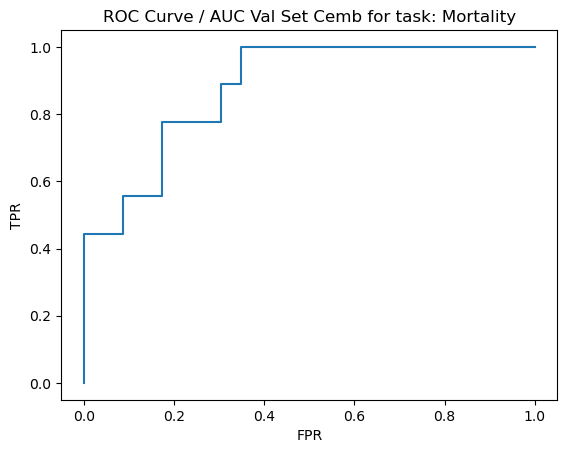

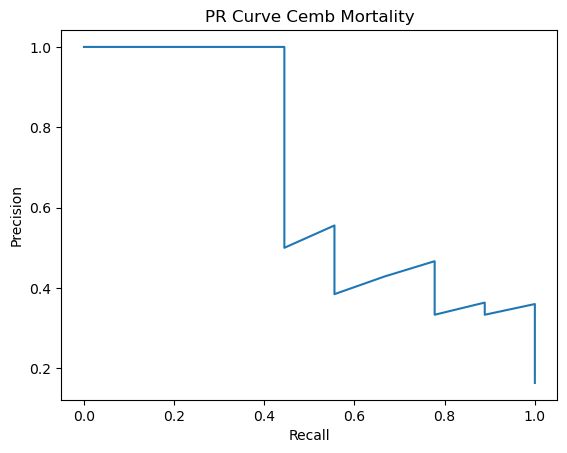

Val AUPRC:  0.68


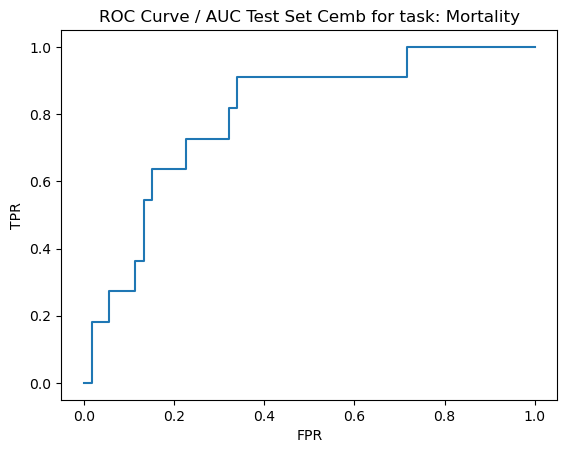

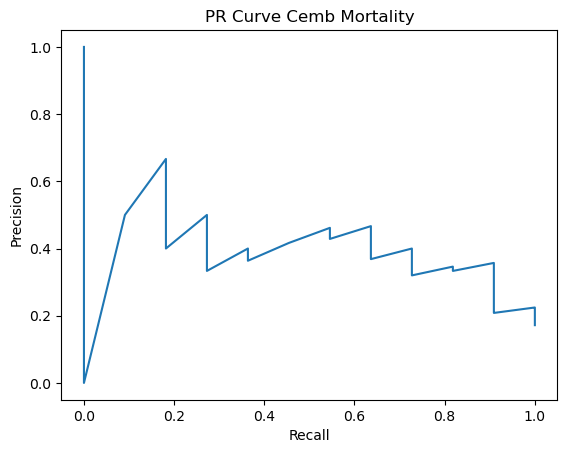

Test AUPRC:  0.38


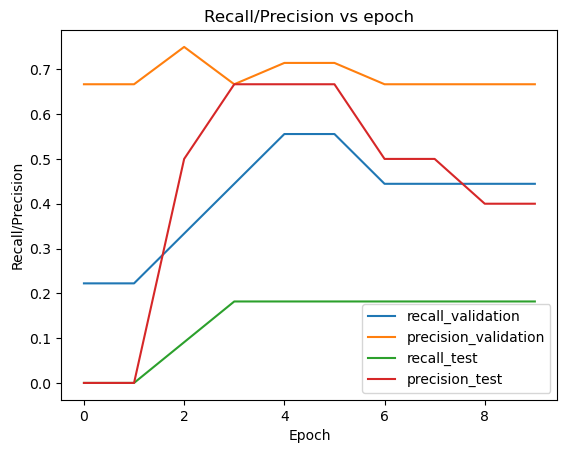

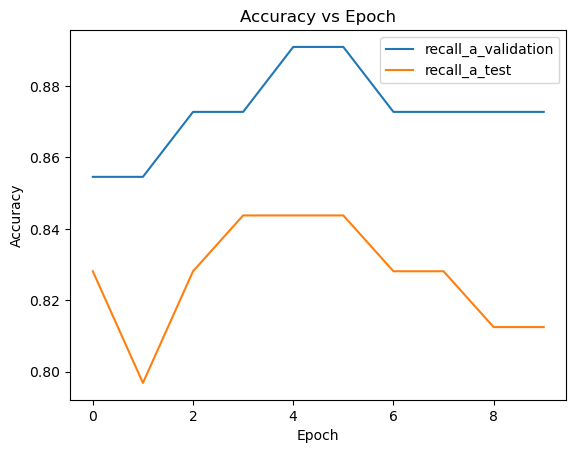

In [54]:
# One entry per epoch in cemb_mort_results.
val_set_results = cemb_mort_dev_results[0]
test_set_results = cemb_mort_dev_results[1]
PrintTrainTime(cemb_mort_dev_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Cemb', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(cemb_mort_dev_results)

### DescEmb - Mort - Dev

In [55]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = True  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb'
args.predict_model_type = 'desc_emb'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_per_patient_collate_function_new_trainer
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-3

In [56]:
trainer = Trainer(args)
demb_mort_dev_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 880, 'dataset_name': 'mortality_pred_task_demb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/8729dbd9621a88deedab5450926d78e3_mortality_pred_task_demb_bs_0_len_880_.pkl`.


Training epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.80it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 1 	 Training Loss: 0.452457


/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 	 Validation p: 0.00, r:0.00, acc:0.85, f: 0.00, roc_auc: 0.70
Epoch: 1 	 Test p: 0.00, r:0.00, acc:0.85, f: 0.00, roc_auc: 0.66
Training epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.02it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 2 	 Training Loss: 0.363639


/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2 	 Validation p: 0.00, r:0.00, acc:0.85, f: 0.00, roc_auc: 0.76
Epoch: 2 	 Test p: 0.00, r:0.00, acc:0.85, f: 0.00, roc_auc: 0.64
Training epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.22it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 3 	 Training Loss: 0.338192


/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3 	 Validation p: 0.00, r:0.00, acc:0.84, f: 0.00, roc_auc: 0.78
Epoch: 3 	 Test p: 0.00, r:0.00, acc:0.85, f: 0.00, roc_auc: 0.68
Training epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.34it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 4 	 Training Loss: 0.313144
Epoch: 4 	 Validation p: 0.75, r:0.23, acc:0.88, f: 0.35, roc_auc: 0.79
Epoch: 4 	 Test p: 0.50, r:0.15, acc:0.85, f: 0.24, roc_auc: 0.69
Training epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.40it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 5 	 Training Loss: 0.295742
Epoch: 5 	 Validation p: 0.67, r:0.15, acc:0.86, f: 0.25, roc_auc: 0.79
Epoch: 5 	 Test p: 0.40, r:0.15, acc:0.84, f: 0.22, roc_auc: 0.69
Training epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.91it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 6 	 Training Loss: 0.274317
Epoch: 6 	 Validation p: 0.67, r:0.31, acc:0.88, f: 0.42, roc_auc: 0.81
Epoch: 6 	 Test p: 0.38, r:0.23, acc:0.83, f: 0.29, roc_auc: 0.72
Training epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.64it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 7 	 Training Loss: 0.253490
Epoch: 7 	 Validation p: 0.67, r:0.15, acc:0.86, f: 0.25, roc_auc: 0.80
Epoch: 7 	 Test p: 0.43, r:0.23, acc:0.84, f: 0.30, roc_auc: 0.73
Training epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.88it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 8 	 Training Loss: 0.221858
Epoch: 8 	 Validation p: 0.50, r:0.08, acc:0.85, f: 0.13, roc_auc: 0.81
Epoch: 8 	 Test p: 0.50, r:0.23, acc:0.85, f: 0.32, roc_auc: 0.74
Training epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.79it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 9 	 Training Loss: 0.194002
Epoch: 9 	 Validation p: 0.30, r:0.62, acc:0.73, f: 0.40, roc_auc: 0.78
Epoch: 9 	 Test p: 0.28, r:0.54, acc:0.73, f: 0.37, roc_auc: 0.75
Training epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.68it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevTrue_best.pt


Epoch: 10 	 Training Loss: 0.212724
Epoch: 10 	 Validation p: 0.60, r:0.23, acc:0.86, f: 0.33, roc_auc: 0.80
Epoch: 10 	 Test p: 0.50, r:0.23, acc:0.85, f: 0.32, roc_auc: 0.75


7723271

Total train time: 3.8e+01 s
Per epoch times: 4.2, 4.1, 4.0, 3.9, 3.9, 3.6, 3.7, 3.6, 3.6, 3.7


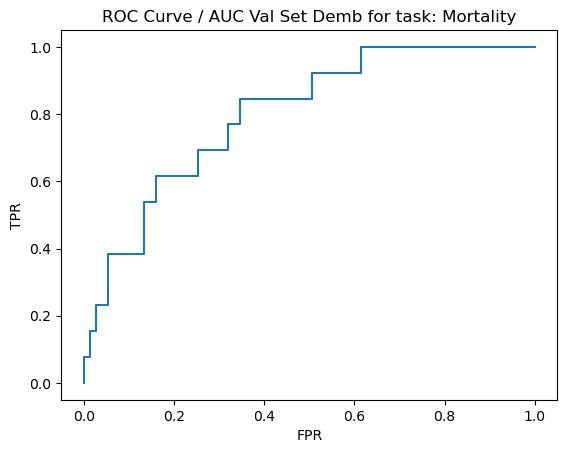

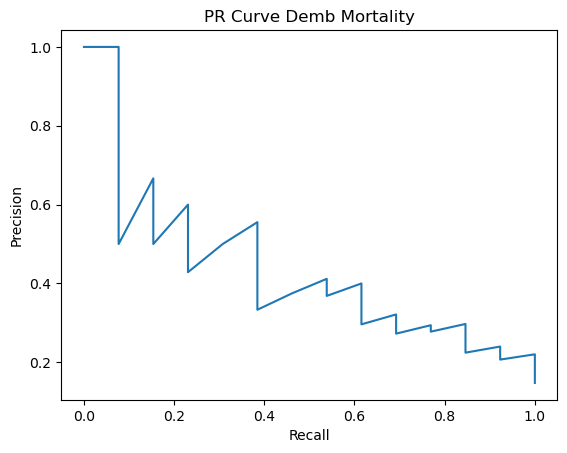

Val AUPRC:  0.43


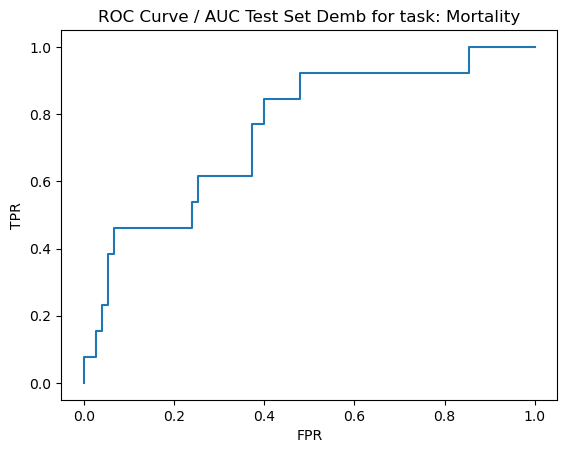

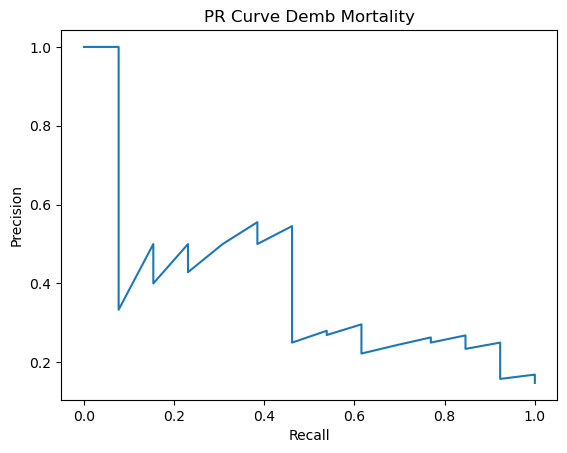

Test AUPRC:  0.39


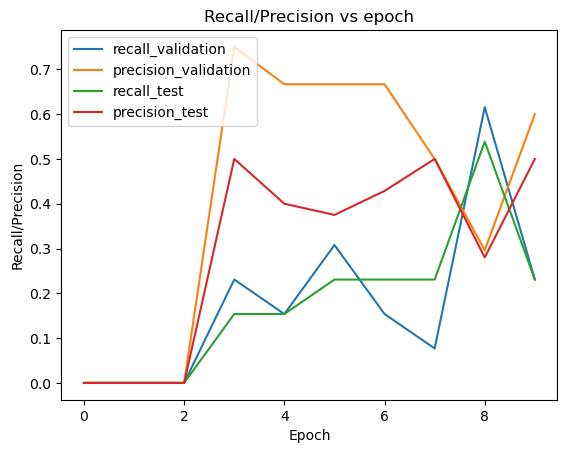

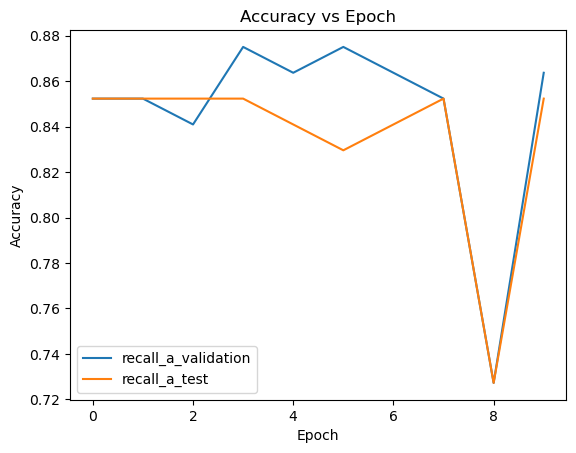

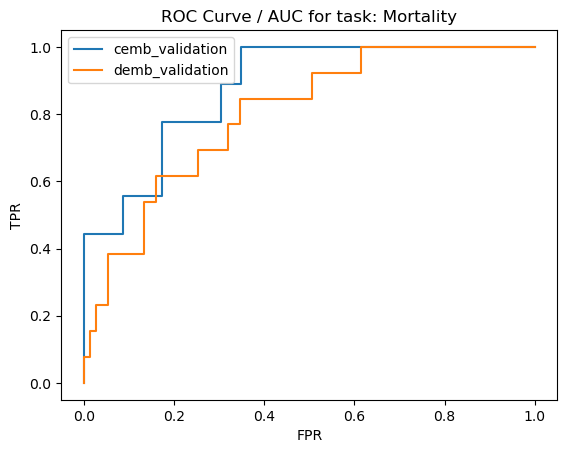

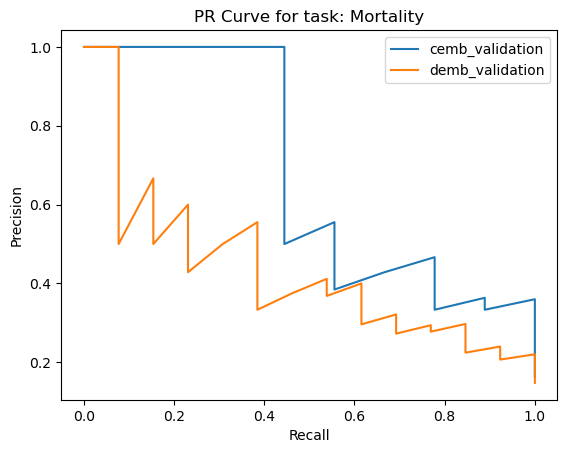

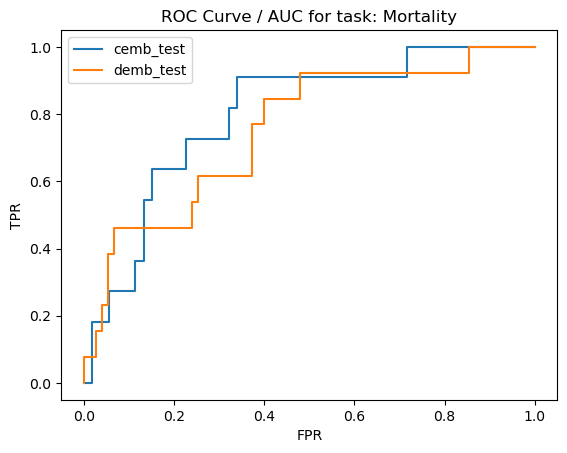

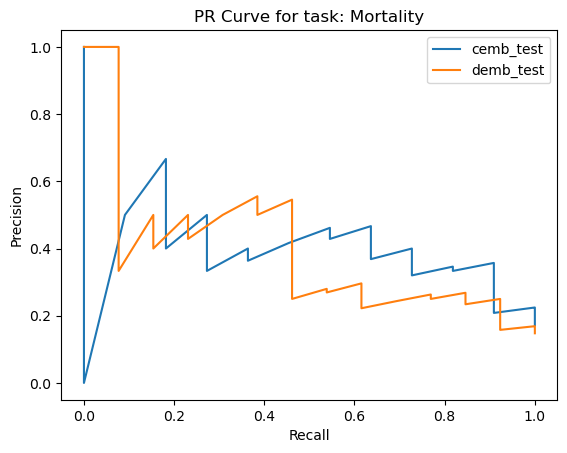

In [57]:
# One entry per epoch in demb_mort_results.
val_set_results = demb_mort_dev_results[0]
test_set_results = demb_mort_dev_results[1]
PrintTrainTime(demb_mort_dev_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Demb', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(demb_mort_dev_results)
labels = ['cemb', 'demb']
PlotDiffResults(cemb_mort_dev_results, demb_mort_dev_results, task_type='Mortality', labels=labels)


### CodeEmb - Readm - Dev

In [58]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# Dev set.
# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456
# READM_DEMB_CODE2IDX 1523
# READM_CEMB_CODE2IDX 1456
# Full set.
# READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: 6555
# MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: 6732
# Full set.
# MORT_DEMB_CODE2IDX 6732
# MORT_CEMB_CODE2IDX 6546

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'readm'
args.db_name = 'mimic'
args.is_dev = True  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'code_emb'
args.predict_model_type = 'code_emb'
args.collate_fn=None
args.embed_index_size = 1456
args.pred_embed_size = 128

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-3

In [59]:
trainer = Trainer(args)
cemb_readm_dev_results = trainer.train()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 631, 'dataset_name': 'readmission_pred_task_cemb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/f548602eae544b41fe3f5eb8c4e85657_readmission_pred_task_cemb_bs_0_len_631_.pkl`.


Training epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 70.63it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 1 	 Training Loss: 0.629309
Epoch: 1 	 Validation p: 0.00, r:0.00, acc:0.75, f: 0.00, roc_auc: 0.43
Epoch: 1 	 Test p: 0.25, r:0.09, acc:0.80, f: 0.13, roc_auc: 0.53
Training epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 68.28it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 2 	 Training Loss: 0.472603
Epoch: 2 	 Validation p: 0.50, r:0.08, acc:0.76, f: 0.13, roc_auc: 0.58
Epoch: 2 	 Test p: 0.25, r:0.09, acc:0.80, f: 0.13, roc_auc: 0.70
Training epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 76.01it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 3 	 Training Loss: 0.354776
Epoch: 3 	 Validation p: 0.80, r:0.31, acc:0.82, f: 0.44, roc_auc: 0.69
Epoch: 3 	 Test p: 0.43, r:0.27, acc:0.81, f: 0.33, roc_auc: 0.79
Training epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 56.18it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 4 	 Training Loss: 0.246024
Epoch: 4 	 Validation p: 0.83, r:0.38, acc:0.84, f: 0.53, roc_auc: 0.80
Epoch: 4 	 Test p: 0.57, r:0.36, acc:0.84, f: 0.44, roc_auc: 0.87
Training epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 76.87it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 5 	 Training Loss: 0.163106
Epoch: 5 	 Validation p: 0.88, r:0.54, acc:0.87, f: 0.67, roc_auc: 0.86
Epoch: 5 	 Test p: 0.62, r:0.45, acc:0.86, f: 0.53, roc_auc: 0.92
Training epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 74.58it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 6 	 Training Loss: 0.103904
Epoch: 6 	 Validation p: 1.00, r:0.69, acc:0.93, f: 0.82, roc_auc: 0.88
Epoch: 6 	 Test p: 0.64, r:0.82, acc:0.89, f: 0.72, roc_auc: 0.94
Training epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 63.99it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 7 	 Training Loss: 0.069185
Epoch: 7 	 Validation p: 1.00, r:0.69, acc:0.93, f: 0.82, roc_auc: 0.88
Epoch: 7 	 Test p: 0.67, r:0.73, acc:0.89, f: 0.70, roc_auc: 0.96
Training epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 69.97it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 8 	 Training Loss: 0.046367
Epoch: 8 	 Validation p: 1.00, r:0.69, acc:0.93, f: 0.82, roc_auc: 0.88
Epoch: 8 	 Test p: 0.67, r:0.73, acc:0.89, f: 0.70, roc_auc: 0.96
Training epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 74.00it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 9 	 Training Loss: 0.032205
Epoch: 9 	 Validation p: 1.00, r:0.69, acc:0.93, f: 0.82, roc_auc: 0.88
Epoch: 9 	 Test p: 0.75, r:0.82, acc:0.92, f: 0.78, roc_auc: 0.96
Training epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 73.79it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevTrue_best.pt


Epoch: 10 	 Training Loss: 0.023734
Epoch: 10 	 Validation p: 1.00, r:0.69, acc:0.93, f: 0.82, roc_auc: 0.88
Epoch: 10 	 Test p: 0.75, r:0.82, acc:0.92, f: 0.78, roc_auc: 0.96


Total train time: 2.9 s
Per epoch times: 0.28, 0.28, 0.27, 0.34, 0.26, 0.27, 0.32, 0.29, 0.27, 0.27


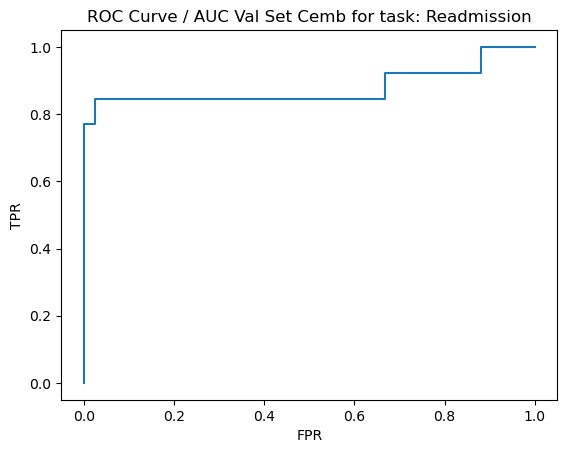

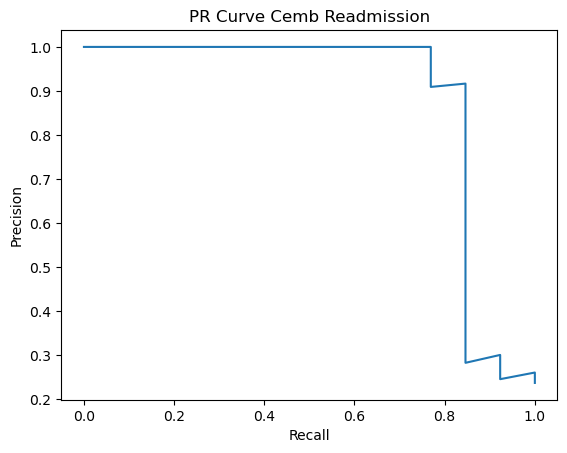

Val AUPRC:  0.88


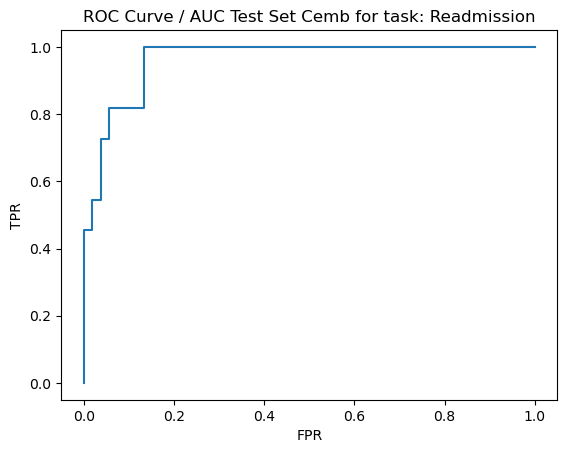

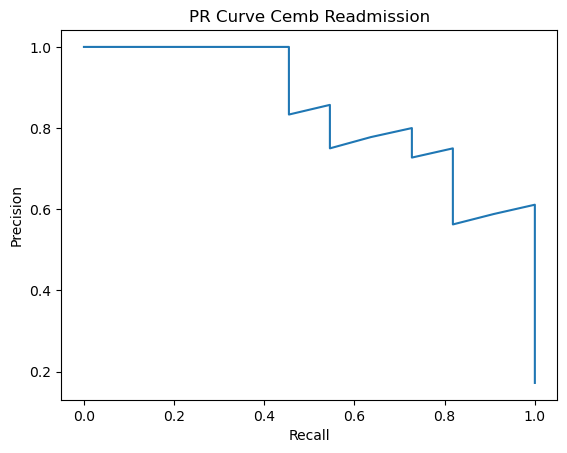

Test AUPRC:  0.85


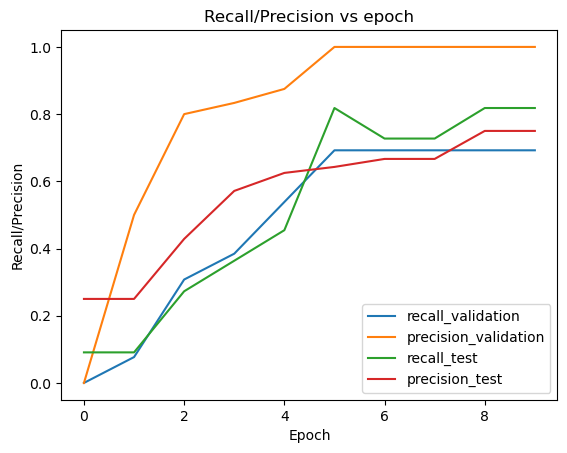

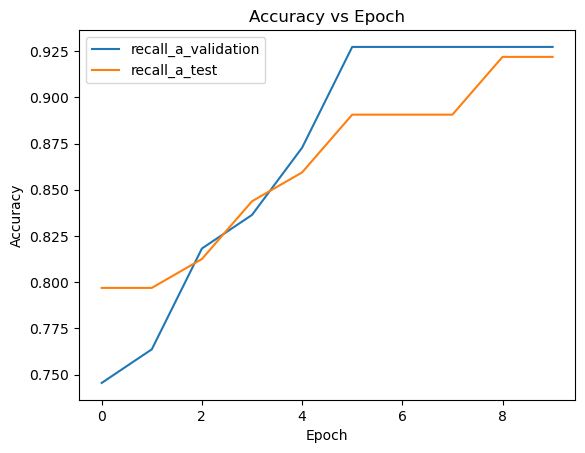

In [60]:
# One entry per epoch in cemb_mort_results.
val_set_results = cemb_readm_dev_results[0]
test_set_results = cemb_readm_dev_results[1]
PrintTrainTime(cemb_readm_dev_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Cemb', task_type='Readmission')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(cemb_readm_dev_results)

### DescEmb - Readm - Dev

In [61]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'readm'
args.db_name = 'mimic'
args.is_dev = True  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb'
args.predict_model_type = 'desc_emb'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_per_patient_collate_function_new_trainer
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-3

In [62]:
trainer = Trainer(args)
demb_readm_dev_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 880, 'dataset_name': 'readmission_pred_task_demb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/6c2cd0e5c00788827a694fb78e63f4da_readmission_pred_task_demb_bs_0_len_880_.pkl`.


Training epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.97it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 1 	 Training Loss: 0.477915


/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 	 Validation p: 0.00, r:0.00, acc:0.78, f: 0.00, roc_auc: 0.89
Epoch: 1 	 Test p: 0.00, r:0.00, acc:0.81, f: 0.00, roc_auc: 0.90
Training epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.70it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 2 	 Training Loss: 0.377953
Epoch: 2 	 Validation p: 1.00, r:0.32, acc:0.85, f: 0.48, roc_auc: 0.91
Epoch: 2 	 Test p: 1.00, r:0.35, acc:0.88, f: 0.52, roc_auc: 0.94
Training epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.98it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 3 	 Training Loss: 0.285809
Epoch: 3 	 Validation p: 0.92, r:0.58, acc:0.90, f: 0.71, roc_auc: 0.90
Epoch: 3 	 Test p: 1.00, r:0.76, acc:0.95, f: 0.87, roc_auc: 0.93
Training epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.02it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 4 	 Training Loss: 0.241246
Epoch: 4 	 Validation p: 0.86, r:0.63, acc:0.90, f: 0.73, roc_auc: 0.88
Epoch: 4 	 Test p: 0.94, r:0.88, acc:0.97, f: 0.91, roc_auc: 0.92
Training epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.02it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 5 	 Training Loss: 0.217115
Epoch: 5 	 Validation p: 0.86, r:0.63, acc:0.90, f: 0.73, roc_auc: 0.88
Epoch: 5 	 Test p: 0.94, r:0.88, acc:0.97, f: 0.91, roc_auc: 0.92
Training epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.32it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 6 	 Training Loss: 0.213001
Epoch: 6 	 Validation p: 0.86, r:0.63, acc:0.90, f: 0.73, roc_auc: 0.87
Epoch: 6 	 Test p: 0.94, r:0.88, acc:0.97, f: 0.91, roc_auc: 0.91
Training epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  6.74it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 7 	 Training Loss: 0.176908
Epoch: 7 	 Validation p: 0.87, r:0.68, acc:0.91, f: 0.76, roc_auc: 0.89
Epoch: 7 	 Test p: 0.71, r:0.88, acc:0.91, f: 0.79, roc_auc: 0.93
Training epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  7.07it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 8 	 Training Loss: 0.168180
Epoch: 8 	 Validation p: 0.80, r:0.63, acc:0.89, f: 0.71, roc_auc: 0.87
Epoch: 8 	 Test p: 0.94, r:0.88, acc:0.97, f: 0.91, roc_auc: 0.92
Training epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.58it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 9 	 Training Loss: 0.124182
Epoch: 9 	 Validation p: 0.92, r:0.63, acc:0.91, f: 0.75, roc_auc: 0.88
Epoch: 9 	 Test p: 1.00, r:0.65, acc:0.93, f: 0.79, roc_auc: 0.93
Training epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:03<00:00,  5.65it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevTrue_best.pt


Epoch: 10 	 Training Loss: 0.102082
Epoch: 10 	 Validation p: 1.00, r:0.58, acc:0.91, f: 0.73, roc_auc: 0.88
Epoch: 10 	 Test p: 1.00, r:0.47, acc:0.90, f: 0.64, roc_auc: 0.92


31225

Total train time: 3.7e+01 s
Per epoch times: 3.6, 3.7, 3.6, 3.5, 3.6, 3.4, 3.7, 3.5, 4.5, 4.3


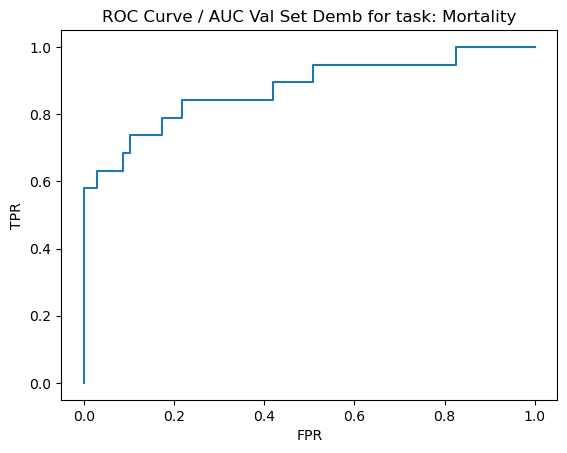

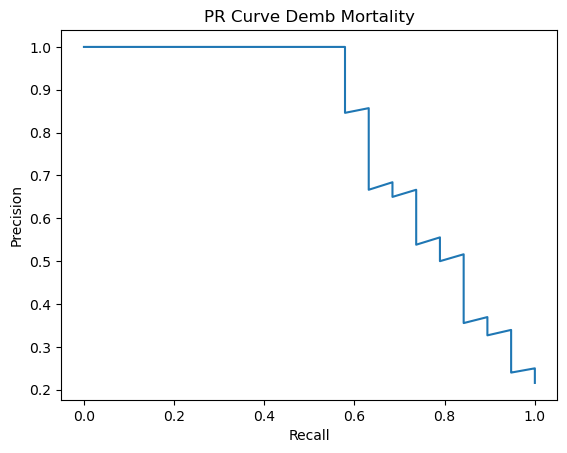

Val AUPRC:  0.8


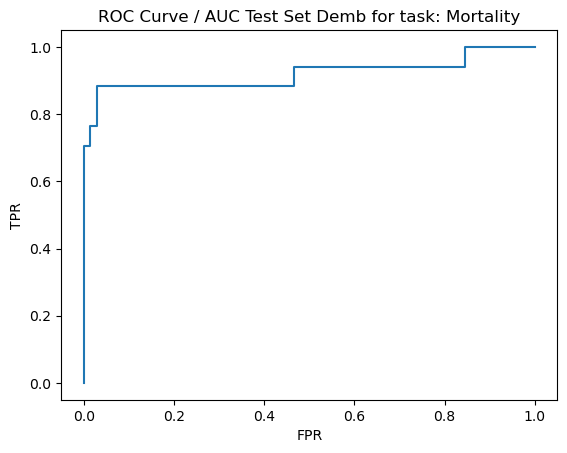

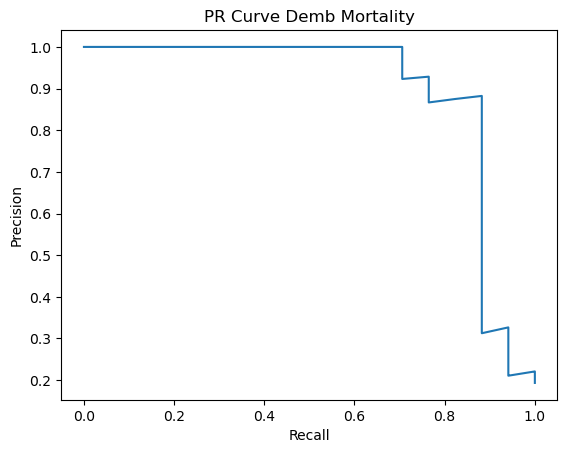

Test AUPRC:  0.89


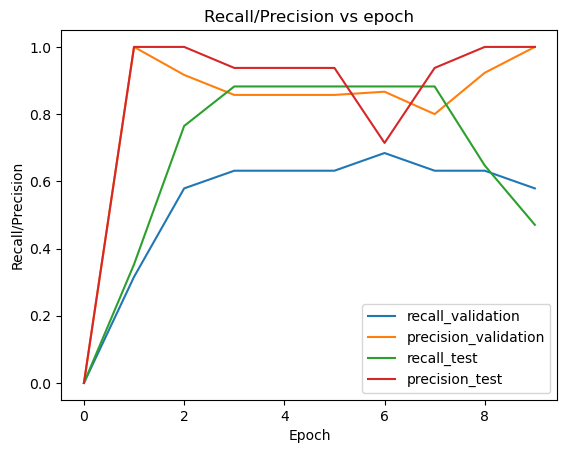

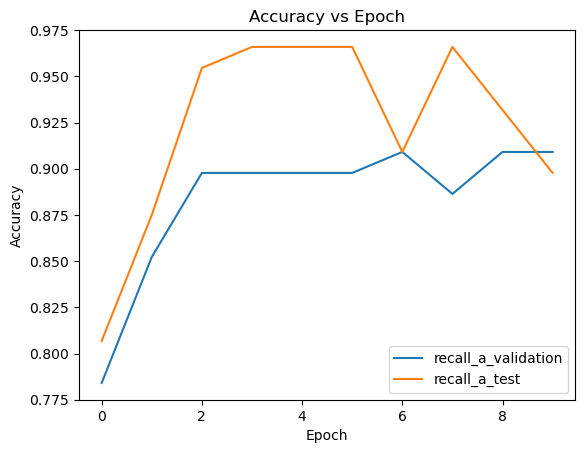

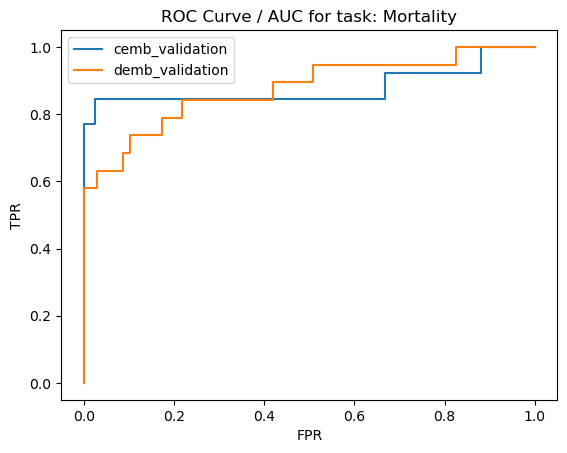

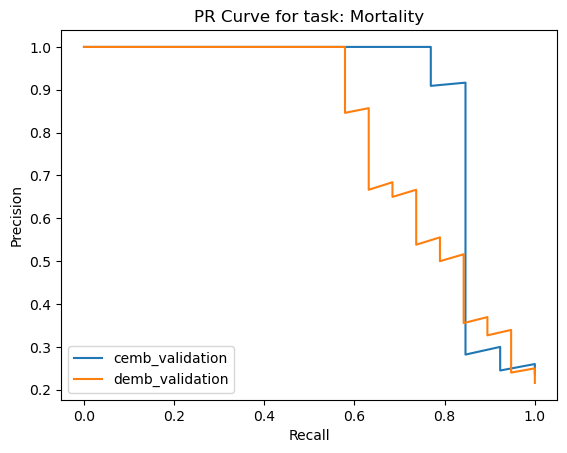

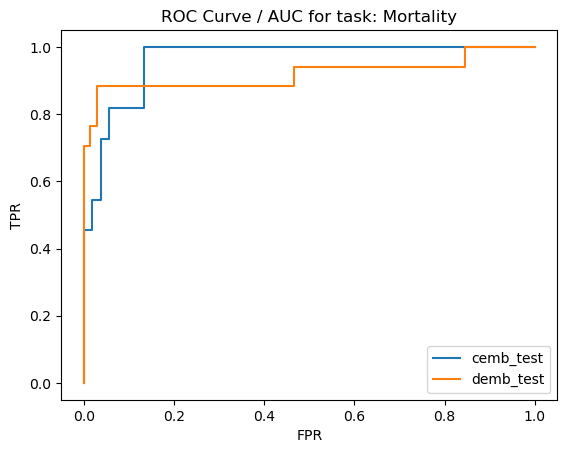

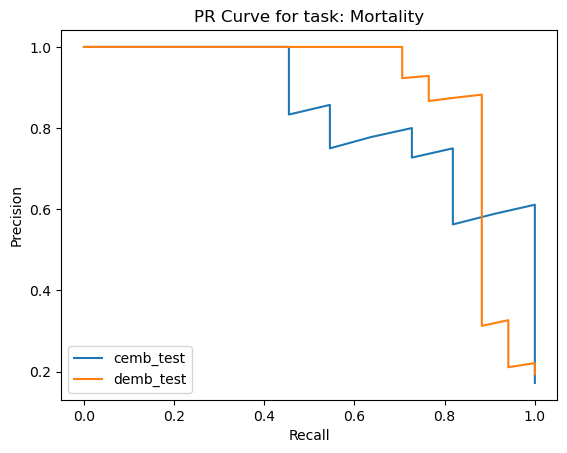

In [63]:
# One entry per epoch in demb_mort_results.
val_set_results = demb_readm_dev_results[0]
test_set_results = demb_readm_dev_results[1]
PrintTrainTime(demb_readm_dev_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Demb', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(demb_readm_dev_results)
labels = ['cemb', 'demb']
PlotDiffResults(cemb_readm_dev_results, demb_readm_dev_results, task_type='Mortality', labels=labels)

### CodeEmb - Mort - Full

In [64]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# Dev set.
# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456
# Full set.
# READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: 6555
# MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: 6732
# Full set.
# MORT_DEMB_CODE2IDX 6732
# MORT_CEMB_CODE2IDX 6546

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'code_emb'
args.predict_model_type = 'code_emb'
args.collate_fn=None
args.embed_index_size = 6546  # mort_cemb_metadata['extra_data']['embed_index_size']
args.pred_embed_size = 128

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [65]:
trainer = Trainer(args)
cemb_mort_full_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 33426, 'dataset_name': 'mortality_pred_task_cemb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/dcebadbfe9794b6810efdeee181c942d_mortality_pred_task_cemb_bs_0_len_33426_.pkl`.


Training epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 58.38it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 1 	 Training Loss: 0.422290
Epoch: 1 	 Validation p: 0.53, r:0.28, acc:0.87, f: 0.37, roc_auc: 0.78
Epoch: 1 	 Test p: 0.56, r:0.26, acc:0.87, f: 0.35, roc_auc: 0.79
Training epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 58.12it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 2 	 Training Loss: 0.317482
Epoch: 2 	 Validation p: 0.63, r:0.34, acc:0.88, f: 0.44, roc_auc: 0.83
Epoch: 2 	 Test p: 0.64, r:0.33, acc:0.88, f: 0.43, roc_auc: 0.84
Training epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:17<00:00, 47.38it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 3 	 Training Loss: 0.280743
Epoch: 3 	 Validation p: 0.63, r:0.39, acc:0.88, f: 0.48, roc_auc: 0.85
Epoch: 3 	 Test p: 0.66, r:0.40, acc:0.89, f: 0.49, roc_auc: 0.86
Training epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:15<00:00, 54.60it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 4 	 Training Loss: 0.256020
Epoch: 4 	 Validation p: 0.65, r:0.39, acc:0.89, f: 0.49, roc_auc: 0.86
Epoch: 4 	 Test p: 0.67, r:0.43, acc:0.89, f: 0.52, roc_auc: 0.87
Training epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 62.25it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 5 	 Training Loss: 0.235648
Epoch: 5 	 Validation p: 0.66, r:0.40, acc:0.89, f: 0.50, roc_auc: 0.86
Epoch: 5 	 Test p: 0.68, r:0.44, acc:0.89, f: 0.53, roc_auc: 0.87
Training epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 62.45it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 6 	 Training Loss: 0.217259
Epoch: 6 	 Validation p: 0.65, r:0.42, acc:0.89, f: 0.51, roc_auc: 0.87
Epoch: 6 	 Test p: 0.67, r:0.46, acc:0.89, f: 0.55, roc_auc: 0.88
Training epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 62.97it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 7 	 Training Loss: 0.199944
Epoch: 7 	 Validation p: 0.66, r:0.42, acc:0.89, f: 0.52, roc_auc: 0.87
Epoch: 7 	 Test p: 0.69, r:0.46, acc:0.90, f: 0.55, roc_auc: 0.88
Training epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 62.53it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 8 	 Training Loss: 0.183696
Epoch: 8 	 Validation p: 0.66, r:0.44, acc:0.89, f: 0.53, roc_auc: 0.87
Epoch: 8 	 Test p: 0.66, r:0.47, acc:0.89, f: 0.55, roc_auc: 0.88
Training epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 63.19it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 9 	 Training Loss: 0.167968
Epoch: 9 	 Validation p: 0.66, r:0.45, acc:0.89, f: 0.54, roc_auc: 0.87
Epoch: 9 	 Test p: 0.65, r:0.46, acc:0.89, f: 0.54, roc_auc: 0.88
Training epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 62.10it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_mort_isdevFalse_best.pt


Epoch: 10 	 Training Loss: 0.152832
Epoch: 10 	 Validation p: 0.66, r:0.44, acc:0.89, f: 0.53, roc_auc: 0.87
Epoch: 10 	 Test p: 0.66, r:0.47, acc:0.89, f: 0.55, roc_auc: 0.88


18405

Total train time: 1.5e+02 s
Per epoch times: 1.6e+01, 1.6e+01, 1.9e+01, 1.7e+01, 1.5e+01, 1.5e+01, 1.4e+01, 1.5e+01, 1.4e+01, 1.5e+01


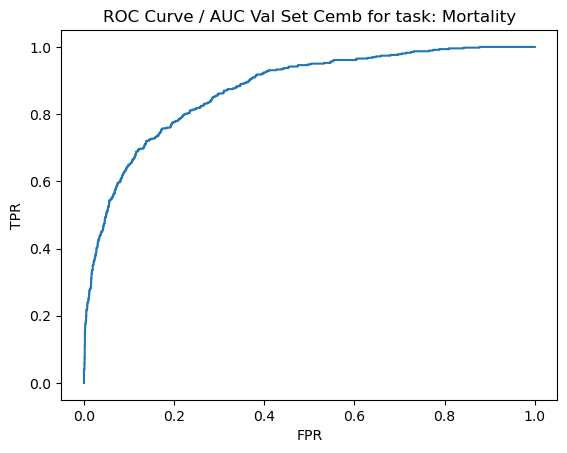

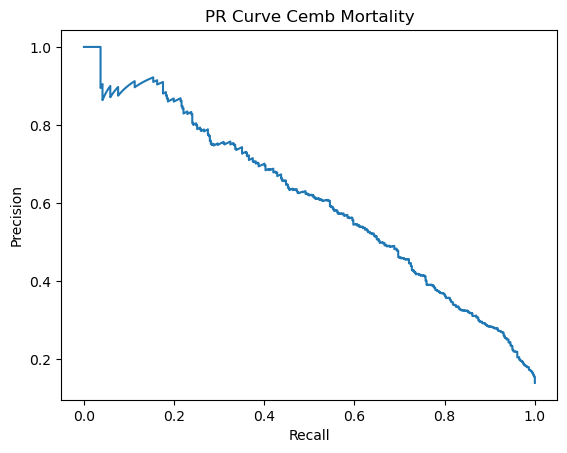

Val AUPRC:  0.61


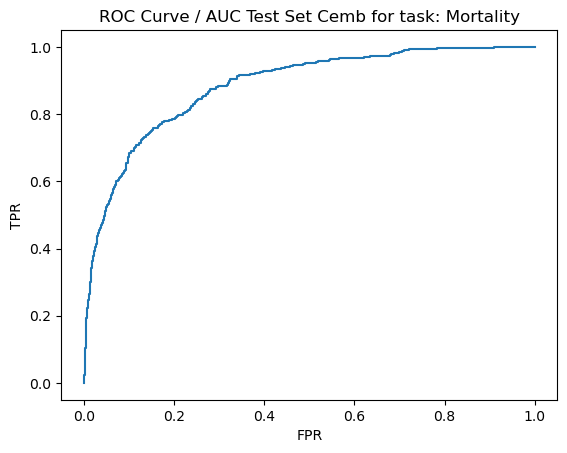

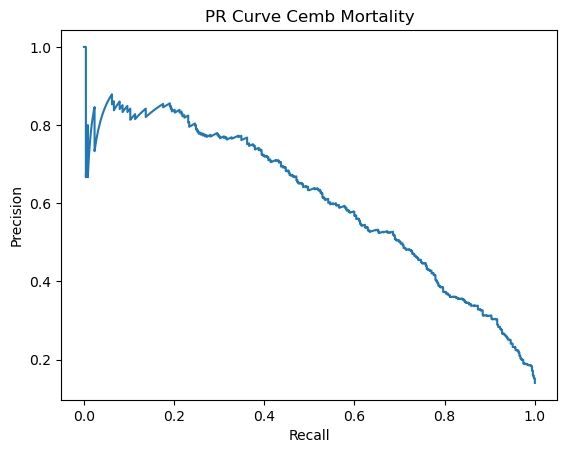

Test AUPRC:  0.61


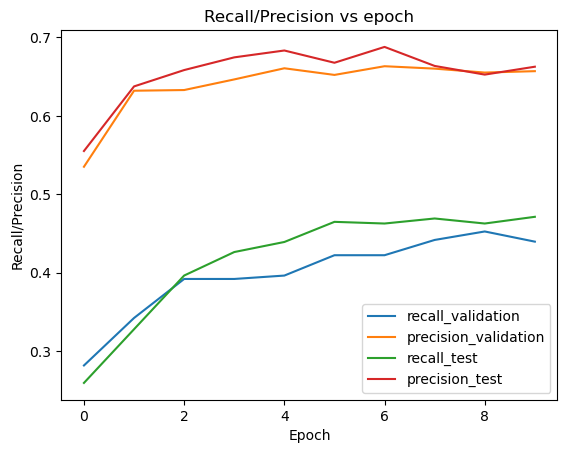

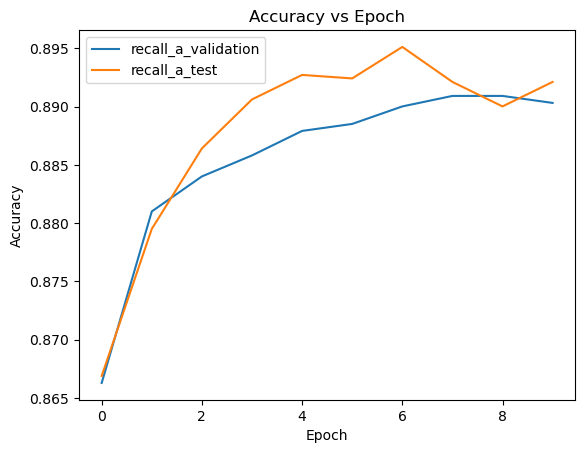

In [66]:
# One entry per epoch in cemb_mort_results.
val_set_results = cemb_mort_full_results[0]
test_set_results = cemb_mort_full_results[1]
PrintTrainTime(cemb_mort_full_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Cemb', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(cemb_mort_full_results)

### DescEmb - Mort - Full

In [67]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb'
args.predict_model_type = 'desc_emb'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_per_patient_collate_function_new_trainer 
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [68]:
trainer = Trainer(args)
demb_mort_full_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 10000, 'dataset_name': 'mortality_pred_task_demb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/34c78953c14427d6601fe35f94890f8d_mortality_pred_task_demb_bs_0_len_10000_.pkl`.


Training epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.02it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 1 	 Training Loss: 0.357327


/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 	 Validation p: 1.00, r:0.01, acc:0.87, f: 0.02, roc_auc: 0.86
Epoch: 1 	 Test p: 0.00, r:0.00, acc:0.84, f: 0.00, roc_auc: 0.84
Training epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  6.98it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 2 	 Training Loss: 0.292412
Epoch: 2 	 Validation p: 0.72, r:0.22, acc:0.89, f: 0.34, roc_auc: 0.90
Epoch: 2 	 Test p: 0.67, r:0.21, acc:0.85, f: 0.32, roc_auc: 0.88
Training epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.11it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 3 	 Training Loss: 0.265684
Epoch: 3 	 Validation p: 0.78, r:0.11, acc:0.88, f: 0.19, roc_auc: 0.91
Epoch: 3 	 Test p: 0.75, r:0.09, acc:0.85, f: 0.16, roc_auc: 0.89
Training epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.01it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 4 	 Training Loss: 0.245806
Epoch: 4 	 Validation p: 0.69, r:0.39, acc:0.90, f: 0.50, roc_auc: 0.92
Epoch: 4 	 Test p: 0.68, r:0.44, acc:0.88, f: 0.53, roc_auc: 0.91
Training epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.09it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 5 	 Training Loss: 0.230362
Epoch: 5 	 Validation p: 0.68, r:0.37, acc:0.89, f: 0.48, roc_auc: 0.92
Epoch: 5 	 Test p: 0.71, r:0.40, acc:0.88, f: 0.52, roc_auc: 0.91
Training epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.80it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 6 	 Training Loss: 0.219201
Epoch: 6 	 Validation p: 0.78, r:0.32, acc:0.90, f: 0.45, roc_auc: 0.92
Epoch: 6 	 Test p: 0.74, r:0.34, acc:0.87, f: 0.46, roc_auc: 0.91
Training epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:41<00:00,  5.98it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 7 	 Training Loss: 0.217553
Epoch: 7 	 Validation p: 0.72, r:0.44, acc:0.90, f: 0.54, roc_auc: 0.92
Epoch: 7 	 Test p: 0.74, r:0.48, acc:0.89, f: 0.58, roc_auc: 0.92
Training epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:40<00:00,  6.21it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 8 	 Training Loss: 0.209410
Epoch: 8 	 Validation p: 0.60, r:0.64, acc:0.90, f: 0.62, roc_auc: 0.93
Epoch: 8 	 Test p: 0.60, r:0.63, acc:0.87, f: 0.61, roc_auc: 0.92
Training epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.58it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 9 	 Training Loss: 0.204400
Epoch: 9 	 Validation p: 0.62, r:0.60, acc:0.90, f: 0.61, roc_auc: 0.93
Epoch: 9 	 Test p: 0.64, r:0.63, acc:0.88, f: 0.63, roc_auc: 0.92
Training epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:38<00:00,  6.49it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


Epoch: 10 	 Training Loss: 0.191556
Epoch: 10 	 Validation p: 0.80, r:0.37, acc:0.91, f: 0.50, roc_auc: 0.92
Epoch: 10 	 Test p: 0.76, r:0.36, acc:0.88, f: 0.49, roc_auc: 0.92


10030

Total train time: 4.1e+02 s
Per epoch times: 3.9e+01, 4e+01, 3.9e+01, 3.9e+01, 3.9e+01, 4.1e+01, 4.6e+01, 4.5e+01, 4.2e+01, 4.3e+01


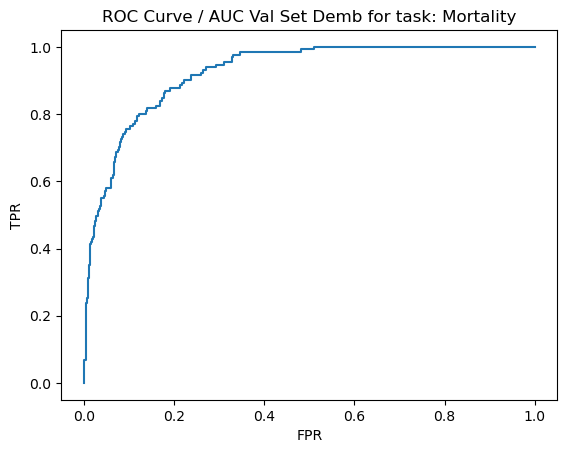

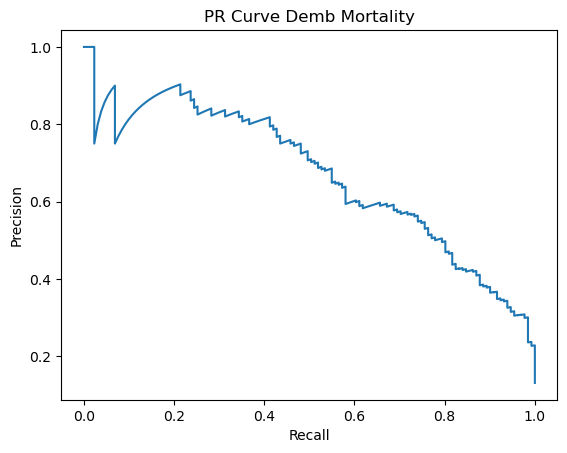

Val AUPRC:  0.67


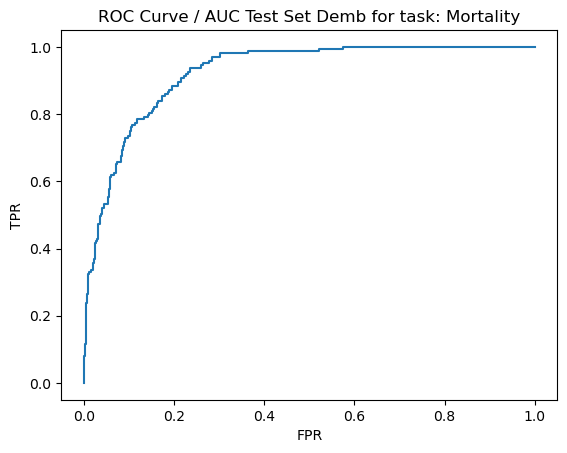

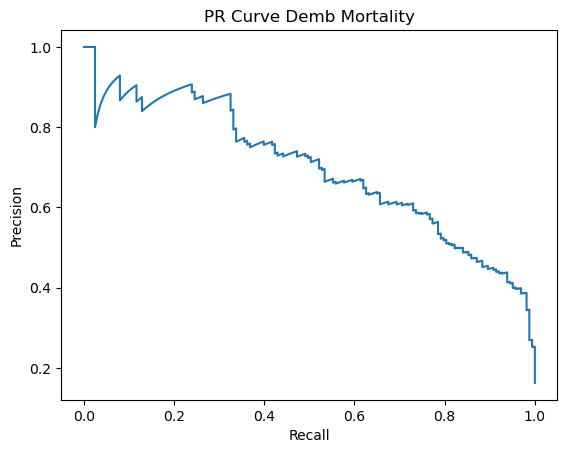

Test AUPRC:  0.7


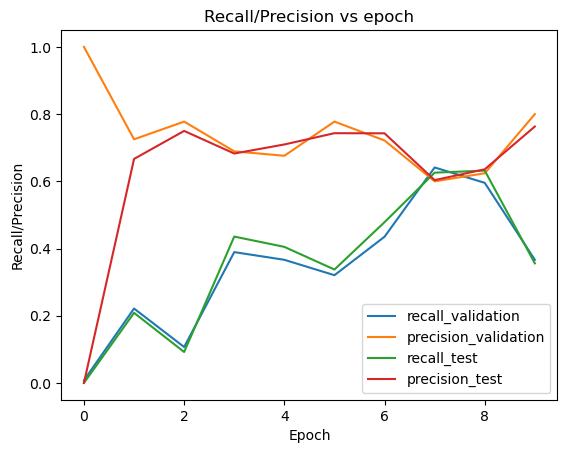

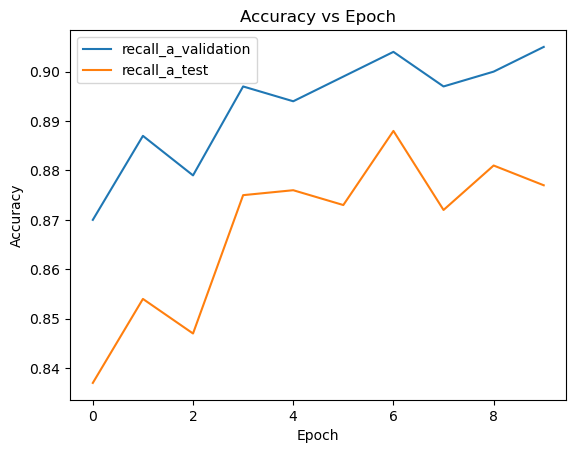

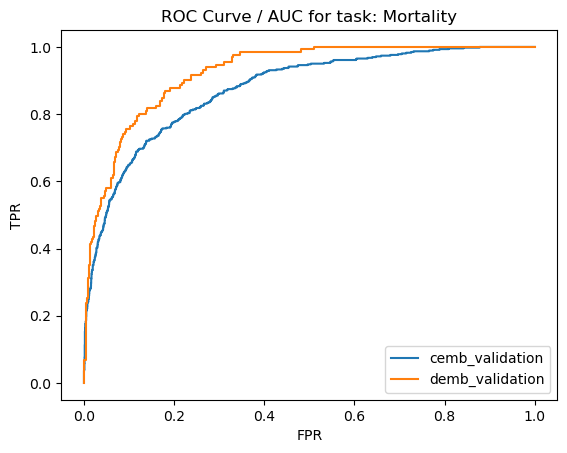

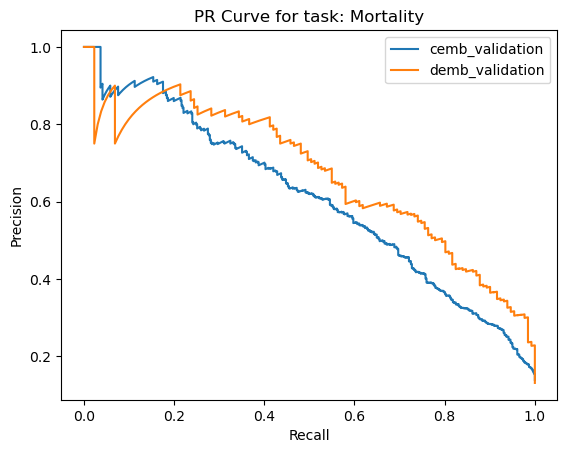

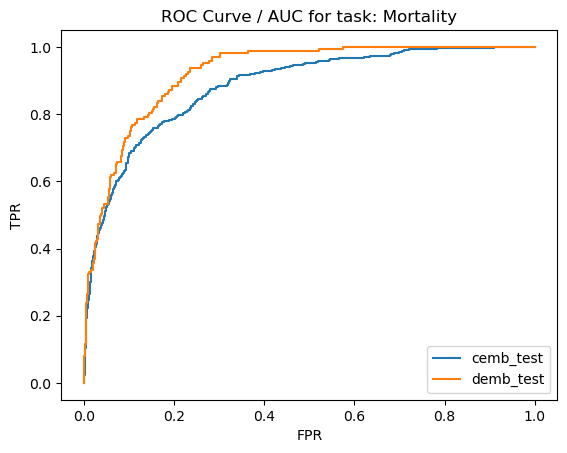

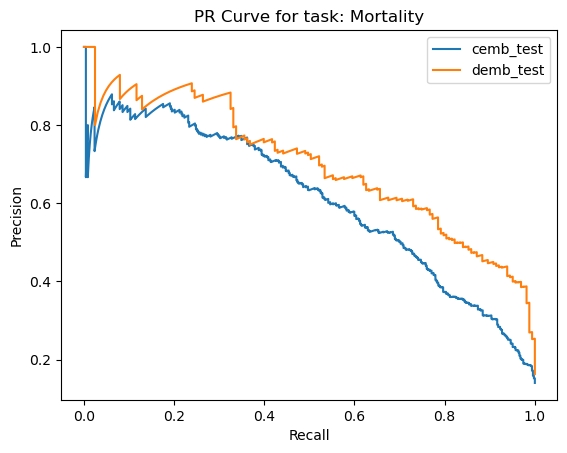

In [69]:
# One entry per epoch in cemb_mort_results.
val_set_results = demb_mort_full_results[0]
test_set_results = demb_mort_full_results[1]
PrintTrainTime(demb_mort_full_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Demb', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(demb_mort_full_results)
labels = ['cemb', 'demb']
PlotDiffResults(cemb_mort_full_results, demb_mort_full_results, task_type='Mortality', labels=labels)

### CodeEmb - Readm - Full 

In [70]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# Dev set.
# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456
# READM_DEMB_CODE2IDX 1523
# READM_CEMB_CODE2IDX 1456
# Full set.
# READMISSION_PER_PATIENT_ICD_9_CODE2IDX_ len: 6555
# MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: 6732
# Full set.
# MORT_DEMB_CODE2IDX 6732
# MORT_CEMB_CODE2IDX 6546

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'readm'
args.db_name = 'mimic'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'code_emb'
args.predict_model_type = 'code_emb'
args.collate_fn=None
args.embed_index_size = 6546
args.pred_embed_size = 128

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [71]:
# 33426 / 32 * 0.8 = 837
trainer = Trainer(args)
cemb_readm_full_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 33426, 'dataset_name': 'readmission_pred_task_cemb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/3791b7d0187d4e9b8f293a78c3928ba1_readmission_pred_task_cemb_bs_0_len_33426_.pkl`.


Training epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:15<00:00, 55.41it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 1 	 Training Loss: 0.478589
Epoch: 1 	 Validation p: 0.94, r:0.64, acc:0.92, f: 0.76, roc_auc: 0.86
Epoch: 1 	 Test p: 0.95, r:0.64, acc:0.92, f: 0.76, roc_auc: 0.87
Training epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 55.96it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 2 	 Training Loss: 0.238920
Epoch: 2 	 Validation p: 0.99, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 2 	 Test p: 0.99, r:0.72, acc:0.94, f: 0.83, roc_auc: 0.88
Training epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:17<00:00, 49.09it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 3 	 Training Loss: 0.204938
Epoch: 3 	 Validation p: 0.99, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 3 	 Test p: 1.00, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.88
Training epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:17<00:00, 47.44it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 4 	 Training Loss: 0.190420
Epoch: 4 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 4 	 Test p: 1.00, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89
Training epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 57.69it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 5 	 Training Loss: 0.179438
Epoch: 5 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 5 	 Test p: 1.00, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89
Training epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 59.08it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 6 	 Training Loss: 0.169375
Epoch: 6 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 6 	 Test p: 1.00, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89
Training epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 59.51it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 7 	 Training Loss: 0.159411
Epoch: 7 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 7 	 Test p: 0.99, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89
Training epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 56.67it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 8 	 Training Loss: 0.149355
Epoch: 8 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 8 	 Test p: 0.99, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89
Training epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:14<00:00, 58.09it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 9 	 Training Loss: 0.139599
Epoch: 9 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 9 	 Test p: 0.99, r:0.72, acc:0.94, f: 0.83, roc_auc: 0.89
Training epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [00:13<00:00, 59.86it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_code_emb_task_readm_isdevFalse_best.pt


Epoch: 10 	 Training Loss: 0.129459
Epoch: 10 	 Validation p: 1.00, r:0.70, acc:0.94, f: 0.82, roc_auc: 0.87
Epoch: 10 	 Test p: 0.99, r:0.72, acc:0.94, f: 0.84, roc_auc: 0.89


17502

Total train time: 1.6e+02 s
Per epoch times: 1.6e+01, 1.6e+01, 1.9e+01, 1.9e+01, 1.6e+01, 1.5e+01, 1.5e+01, 1.6e+01, 1.6e+01, 1.5e+01


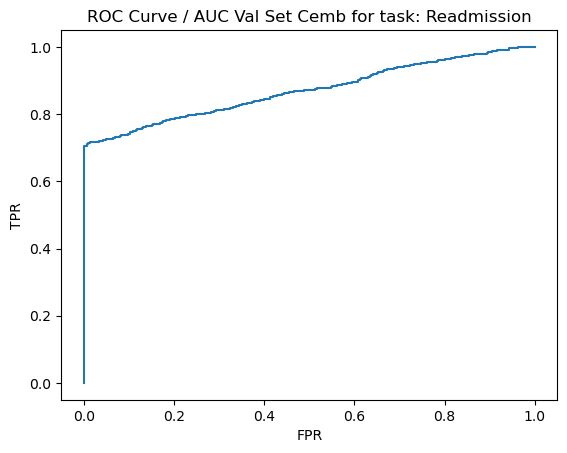

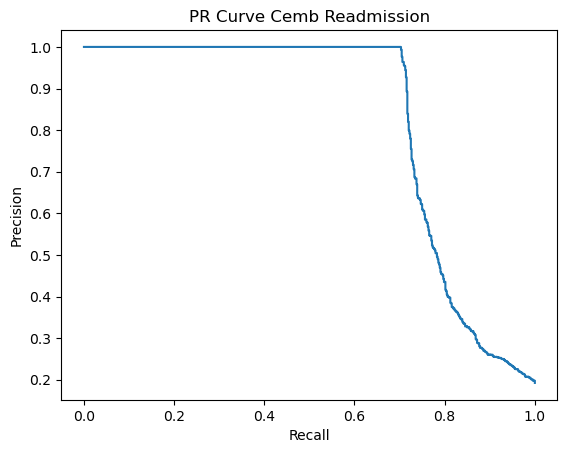

Val AUPRC:  0.82


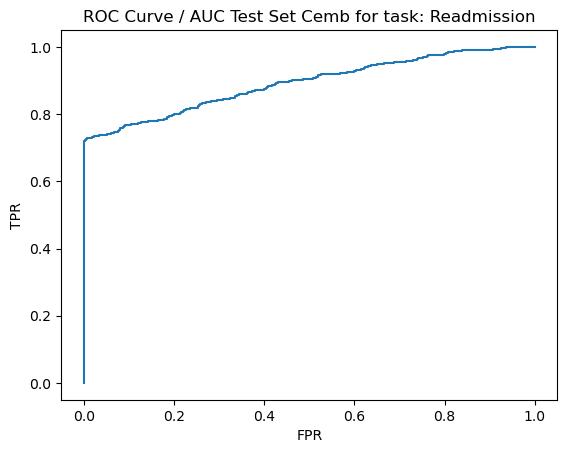

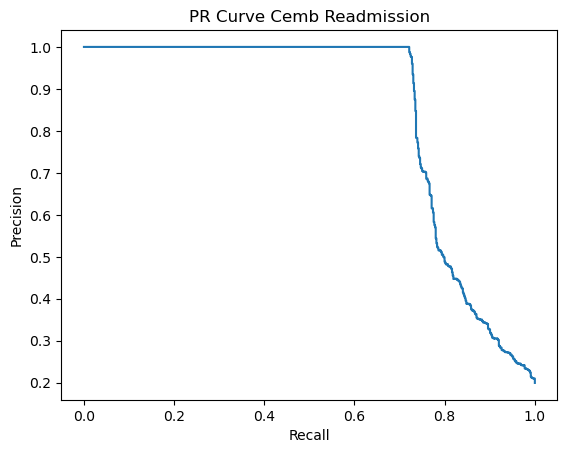

Test AUPRC:  0.84


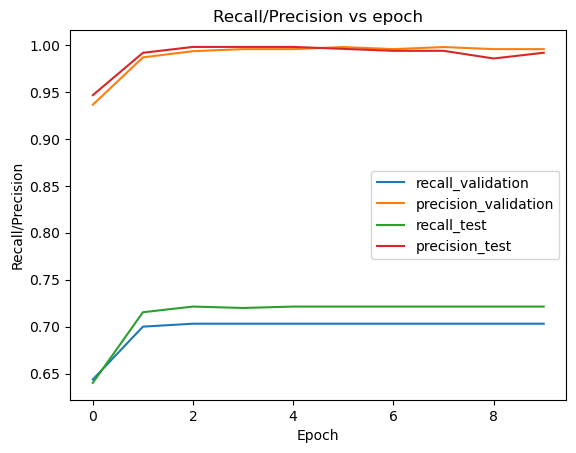

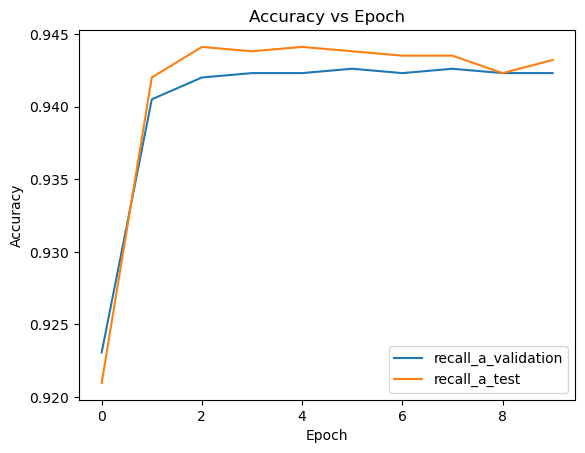

In [72]:
# One entry per epoch in cemb_mort_results.
val_set_results = cemb_readm_full_results[0]
test_set_results = cemb_readm_full_results[1]
PrintTrainTime(cemb_readm_full_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Cemb', task_type='Readmission')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(cemb_readm_full_results)

### DescEmb - Readm - Full 

In [73]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'readm'
args.db_name = 'mimic'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb'
args.predict_model_type = 'desc_emb'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_per_patient_collate_function_new_trainer
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [74]:
# 10000 / 32 * 0.8 = 250
trainer = Trainer(args)
demb_readm_full_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 10000, 'dataset_name': 'readmission_pred_task_demb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/cd5d538e4dfed204bfa09a2e61ce3881_readmission_pred_task_demb_bs_0_len_10000_.pkl`.


Training epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.15it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 1 	 Training Loss: 0.363902
Epoch: 1 	 Validation p: 0.95, r:0.49, acc:0.90, f: 0.64, roc_auc: 0.89
Epoch: 1 	 Test p: 0.96, r:0.48, acc:0.90, f: 0.64, roc_auc: 0.90
Training epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.93it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 2 	 Training Loss: 0.250097
Epoch: 2 	 Validation p: 0.88, r:0.64, acc:0.92, f: 0.74, roc_auc: 0.90
Epoch: 2 	 Test p: 0.92, r:0.64, acc:0.92, f: 0.76, roc_auc: 0.90
Training epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:42<00:00,  5.83it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 3 	 Training Loss: 0.236849
Epoch: 3 	 Validation p: 0.83, r:0.71, acc:0.92, f: 0.77, roc_auc: 0.90
Epoch: 3 	 Test p: 0.85, r:0.71, acc:0.92, f: 0.77, roc_auc: 0.91
Training epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:44<00:00,  5.63it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 4 	 Training Loss: 0.225739
Epoch: 4 	 Validation p: 0.89, r:0.68, acc:0.93, f: 0.77, roc_auc: 0.90
Epoch: 4 	 Test p: 0.92, r:0.66, acc:0.93, f: 0.77, roc_auc: 0.91
Training epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.78it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 5 	 Training Loss: 0.221806
Epoch: 5 	 Validation p: 0.94, r:0.67, acc:0.93, f: 0.78, roc_auc: 0.90
Epoch: 5 	 Test p: 0.94, r:0.64, acc:0.93, f: 0.77, roc_auc: 0.91
Training epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.10it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 6 	 Training Loss: 0.211127
Epoch: 6 	 Validation p: 0.97, r:0.66, acc:0.94, f: 0.78, roc_auc: 0.91
Epoch: 6 	 Test p: 0.97, r:0.65, acc:0.93, f: 0.78, roc_auc: 0.91
Training epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:36<00:00,  6.83it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 7 	 Training Loss: 0.201090
Epoch: 7 	 Validation p: 0.85, r:0.77, acc:0.94, f: 0.81, roc_auc: 0.91
Epoch: 7 	 Test p: 0.87, r:0.75, acc:0.93, f: 0.81, roc_auc: 0.91
Training epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:42<00:00,  5.95it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 8 	 Training Loss: 0.194075
Epoch: 8 	 Validation p: 0.87, r:0.77, acc:0.94, f: 0.82, roc_auc: 0.91
Epoch: 8 	 Test p: 0.88, r:0.76, acc:0.94, f: 0.81, roc_auc: 0.91
Training epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:45<00:00,  5.50it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 9 	 Training Loss: 0.188456
Epoch: 9 	 Validation p: 0.86, r:0.79, acc:0.94, f: 0.83, roc_auc: 0.91
Epoch: 9 	 Test p: 0.86, r:0.77, acc:0.94, f: 0.81, roc_auc: 0.91
Training epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.67it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt
INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_readm_isdevFalse_best.pt


Epoch: 10 	 Training Loss: 0.180898
Epoch: 10 	 Validation p: 0.87, r:0.79, acc:0.94, f: 0.83, roc_auc: 0.91
Epoch: 10 	 Test p: 0.86, r:0.78, acc:0.94, f: 0.82, roc_auc: 0.91


10711

Total train time: 4.4e+02 s
Per epoch times: 3.9e+01, 4.1e+01, 4.7e+01, 4.9e+01, 4.1e+01, 3.9e+01, 4.1e+01, 4.7e+01, 5e+01, 4.1e+01


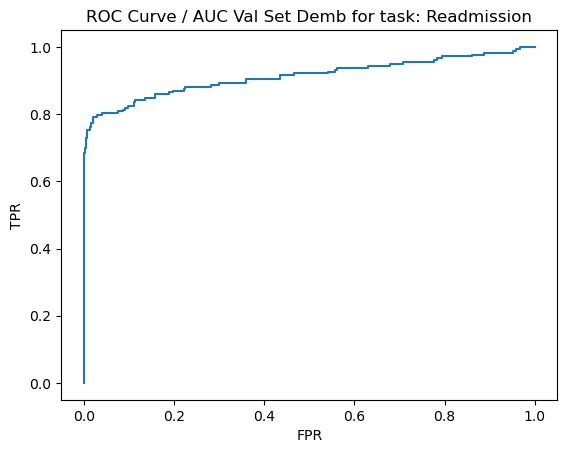

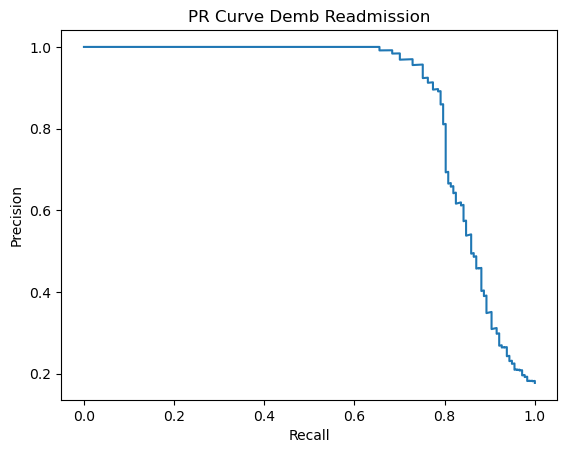

Val AUPRC:  0.87


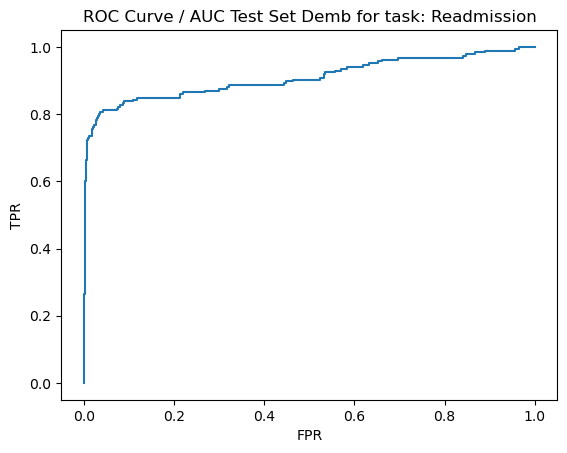

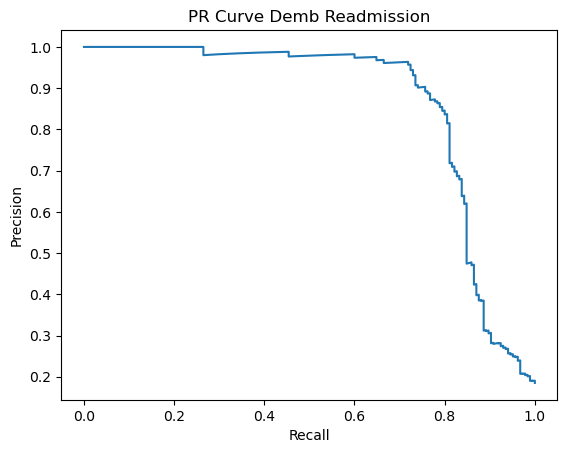

Test AUPRC:  0.86


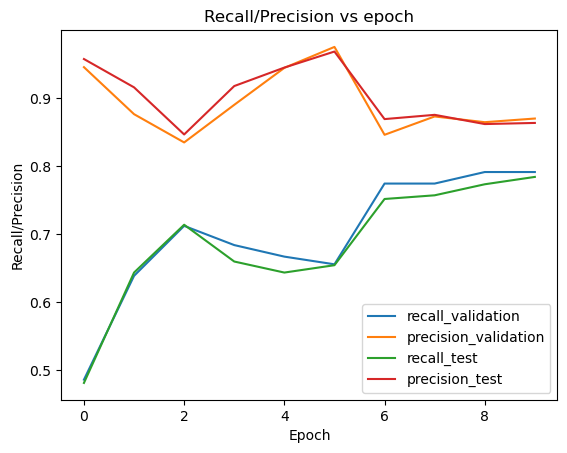

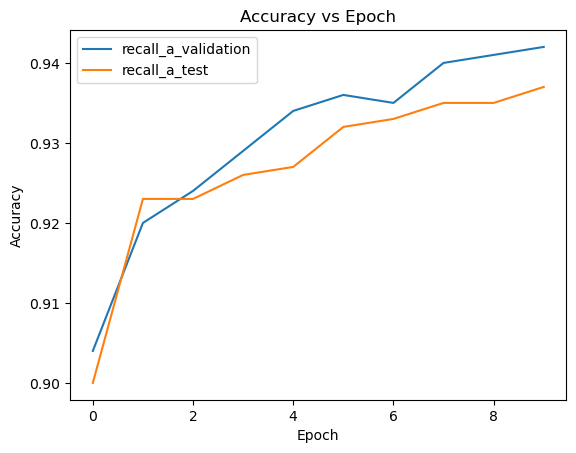

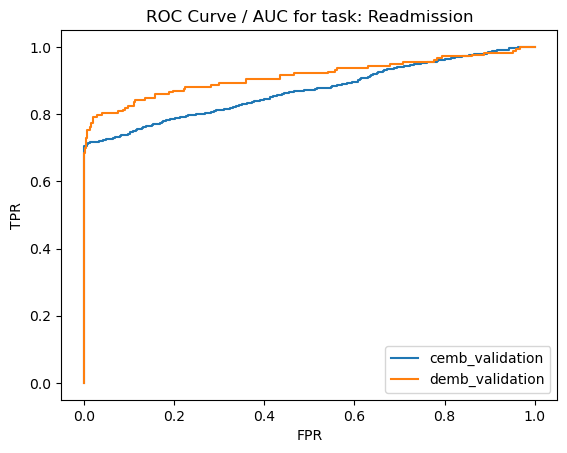

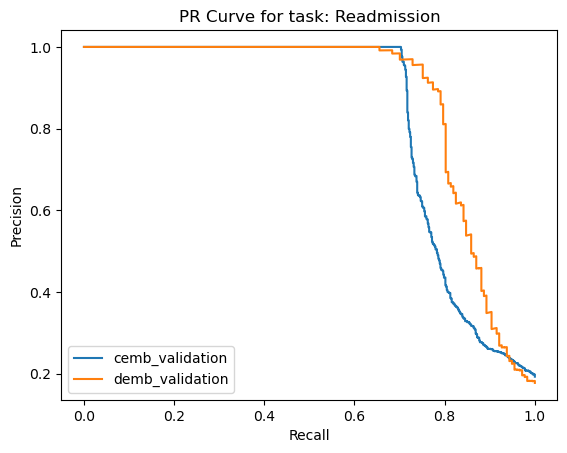

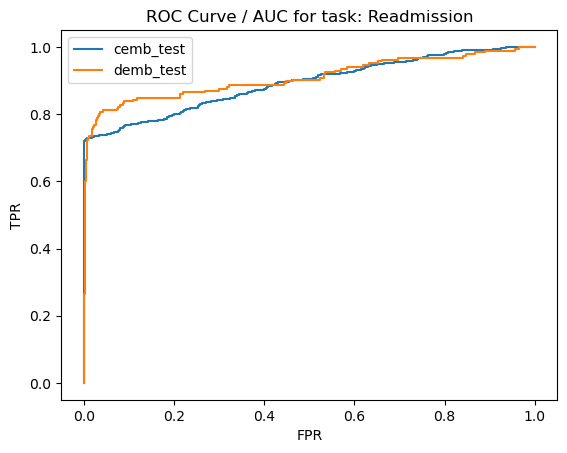

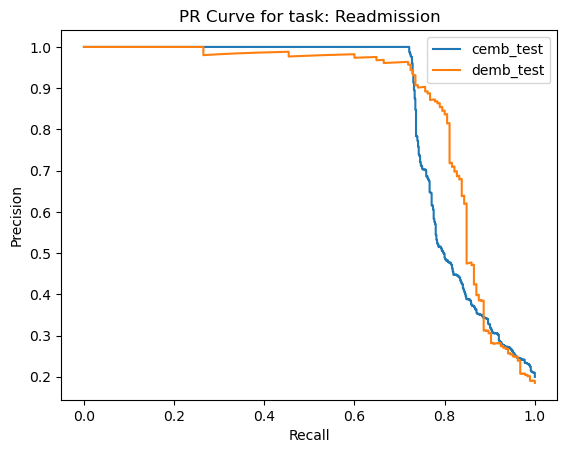

In [75]:
# One entry per epoch in demb_mort_results.
val_set_results = demb_readm_full_results[0]
test_set_results = demb_readm_full_results[1]
PrintTrainTime(demb_readm_full_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Demb', task_type='Readmission')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(demb_readm_full_results)
labels = ['cemb', 'demb']
PlotDiffResults(cemb_readm_full_results, demb_readm_full_results, task_type='Readmission', labels=labels)

### DescEmbFt - Mort - Dev

In [76]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher
import torch
# from GPUtil import showUtilization as gpu_usage

# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = True  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb_ft'
args.predict_model_type = 'desc_emb_ft'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_fine_tune_collate
args.no_use_cached_dataset = mortality_dembft_dataset
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [77]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))
gc.collect()
del trainer
gc.collect()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

NameError: name 'trainer' is not defined

In [ ]:
trainer = Trainer(args)
dembft_mort_dev_results = trainer.train()

In [ ]:
# One entry per epoch in demb_mort_results.
val_set_results = dembft_mort_dev_results[0]
test_set_results = dembft_mort_dev_results[1]
PrintTrainTime(dembft_mort_dev_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Dembft', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(dembft_mort_dev_results)

### DescEmbFt - Mort - Full 

In [80]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher


# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'mimic'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.embed_model_type = 'desc_emb_ft'
args.predict_model_type = 'desc_emb_ft'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_fine_tune_collate
args.no_use_cached_dataset = mortality_dembft_dataset
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 


# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [81]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))
gc.collect()
del trainer
gc.collect()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  84984 KiB | 712746 KiB |    981 GiB |    981 GiB |
|       from large pool |  77684 KiB | 702870 KiB |    960 GiB |    960 GiB |
|       from small pool |   7300 KiB |  11480 KiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  84984 KiB | 712746 KiB |    981 GiB |    981 GiB |
|       from large pool |  77684 KiB | 702870 KiB |    960 GiB |

NameError: name 'trainer' is not defined

In [82]:
trainer = Trainer(args)
dembft_mort_full_results = trainer.train()

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In DembFtEmbed constructor, before BERT.
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  84984 KiB | 712746 KiB |    981 GiB |    981 GiB |
|       from large pool |  77684 KiB | 702870 KiB |    960 GiB |    960 GiB |
|       from small pool |   7300 KiB |  11480 KiB |     21 GiB |     21 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  84984 KiB | 712746 KiB |    981 GiB |    981 GiB |
|       from large pool

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.71it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 1 	 Training Loss: 0.400042


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abot/sw/anaconda3/envs/cs598_dlh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1 	 Validation p: 0.00, r:0.00, acc:0.88, f: 0.00, roc_auc: 0.65
Epoch: 1 	 Test p: 0.00, r:0.00, acc:0.86, f: 0.00, roc_auc: 0.70
Training epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:55<00:00,  4.51it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 2 	 Training Loss: 0.373894


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 2 	 Validation p: 0.20, r:0.01, acc:0.87, f: 0.02, roc_auc: 0.74
Epoch: 2 	 Test p: 0.14, r:0.01, acc:0.86, f: 0.01, roc_auc: 0.74
Training epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.64it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 3 	 Training Loss: 0.345198


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 3 	 Validation p: 0.48, r:0.18, acc:0.87, f: 0.26, roc_auc: 0.77
Epoch: 3 	 Test p: 0.29, r:0.09, acc:0.85, f: 0.14, roc_auc: 0.79
Training epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:54<00:00,  4.59it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 4 	 Training Loss: 0.312137


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 4 	 Validation p: 0.63, r:0.21, acc:0.89, f: 0.31, roc_auc: 0.82
Epoch: 4 	 Test p: 0.43, r:0.12, acc:0.86, f: 0.19, roc_auc: 0.83
Training epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.64it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 5 	 Training Loss: 0.288334


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 5 	 Validation p: 0.60, r:0.28, acc:0.89, f: 0.38, roc_auc: 0.83
Epoch: 5 	 Test p: 0.48, r:0.21, acc:0.86, f: 0.30, roc_auc: 0.84
Training epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.66it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 6 	 Training Loss: 0.271618


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 6 	 Validation p: 0.67, r:0.30, acc:0.89, f: 0.41, roc_auc: 0.84
Epoch: 6 	 Test p: 0.49, r:0.24, acc:0.86, f: 0.32, roc_auc: 0.84
Training epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.67it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 7 	 Training Loss: 0.264828


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 7 	 Validation p: 0.70, r:0.26, acc:0.89, f: 0.37, roc_auc: 0.84
Epoch: 7 	 Test p: 0.58, r:0.19, acc:0.87, f: 0.28, roc_auc: 0.85
Training epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:54<00:00,  4.61it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 8 	 Training Loss: 0.256765


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 8 	 Validation p: 0.66, r:0.37, acc:0.90, f: 0.47, roc_auc: 0.84
Epoch: 8 	 Test p: 0.52, r:0.28, acc:0.87, f: 0.37, roc_auc: 0.86
Training epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:54<00:00,  4.62it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 9 	 Training Loss: 0.247874


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 9 	 Validation p: 0.63, r:0.42, acc:0.90, f: 0.50, roc_auc: 0.85
Epoch: 9 	 Test p: 0.52, r:0.32, acc:0.87, f: 0.40, roc_auc: 0.85
Training epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:53<00:00,  4.67it/s]
INFO:trainlib.trainer:Saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 10 	 Training Loss: 0.240619


INFO:trainlib.trainer:Finished saving checkpoint to /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_ft_task_mort_isdevFalse_best.pt


Epoch: 10 	 Validation p: 0.68, r:0.27, acc:0.89, f: 0.39, roc_auc: 0.84
Epoch: 10 	 Test p: 0.54, r:0.19, acc:0.87, f: 0.28, roc_auc: 0.85


Total train time: 6.6e+02 s
Per epoch times: 6.5e+01, 6.7e+01, 6.6e+01, 6.6e+01, 6.6e+01, 6.6e+01, 6.5e+01, 6.6e+01, 6.6e+01, 6.5e+01


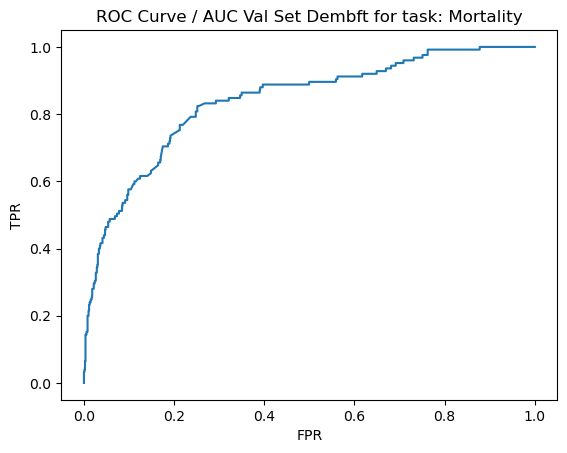

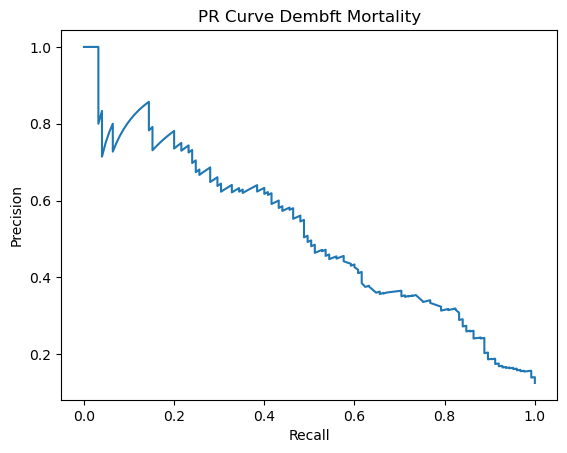

Val AUPRC:  0.51


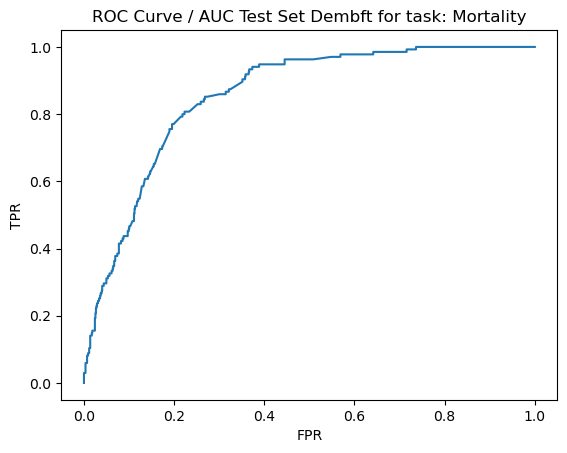

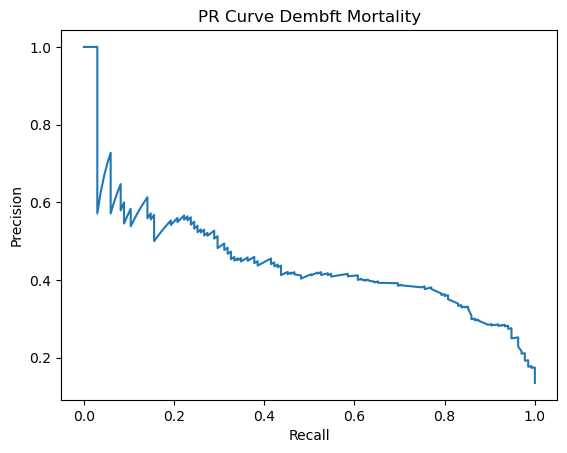

Test AUPRC:  0.45


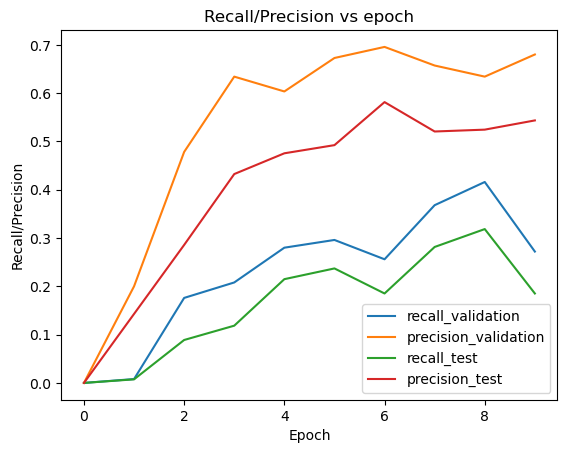

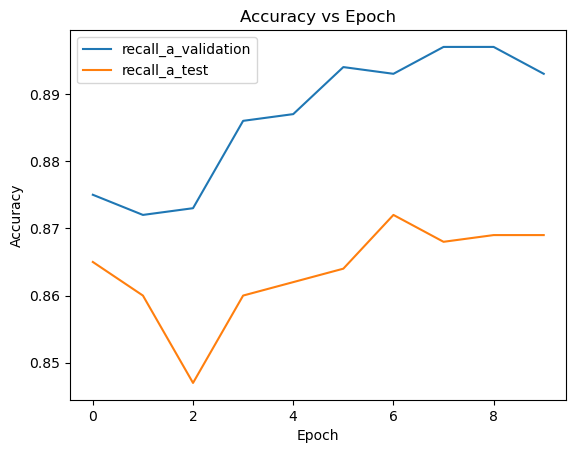

In [83]:
# One entry per epoch in cemb_mort_results.
val_set_results = dembft_mort_full_results[0]
test_set_results = dembft_mort_full_results[1]
PrintTrainTime(dembft_mort_full_results[2])
PlotAucRecallResults(val_set_results[-1], test_set_results[-1],
                     emb_type='Dembft', task_type='Mortality')
PlotPrecisionRecallAcrossEpoch(val_set_results, test_set_results)
PlotAccuracyAcrossEpoch(dembft_mort_full_results)

# eICU Eval

In [99]:
def eval_model(model, data_loader):
    model.eval()
    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()
    # for x, masks, rev_x, rev_masks, y in val_loader:
    for sample_dict in tqdm.tqdm(data_loader):
        y = sample_dict['y']
        y_hat = model(**sample_dict)
        y_score = torch.cat((y_score,  y_hat.detach().to('cpu')), dim=0)
        y_hat = (y_hat > 0.5).int()
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)
    """
    TODO:
        Calculate precision, recall, f1, and roc auc scores.
        Use `average='binary'` for calculating precision, recall, and fscore.
    """
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)
    rcurve = roc_curve(y_true, y_score)
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_score)
    accuracy = accuracy_score(y_true, y_pred)
    return [(p, r, f, roc_auc, rcurve, precision_curve, recall_curve, accuracy)]


def load_model_state_from_file(fname):
    path = os.path.join(os.getcwd(), 'modelcache', fname)
    d = torch.load(path)
    model_state_dict = d['model_state_dict']
    args = d['args']
    print(f'Loading model state with args{args} from \n {path}')
    return model_state_dict, args


def load_model_from_file(embed_model_type: str,
                         task: str,
                         is_dev: bool):
    fname = f'model_{embed_model_type}_task_{task}_isdev{is_dev}'
    fname = fname + "_best.pt"
    model_state_dict, args = load_model_state_from_file(fname)
    model = EHRModel(args)
    model.load_state_dict(model_state_dict)
    model.eval()
    return model, args

### DescEMB eICU Pred Task

See tasks/eicu_funcs.py

### Test Load Mortality Dataset

In [ ]:
if False:
    EICU_MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_ = {}
    EICU_MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {}
    task_fn = functools.partial(eicu_mortality_pred_task_demb, EICU_MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_)
    eicu_mor_dataset = eicubase.set_task(task_fn, task_name=eicu_mortality_pred_task_demb.__name__)
    EICU_MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ = {
        code: idx for idx, code in enumerate(sorted(EICU_MORTALITY_PER_PATIENT_ICD_9_CODE_COUNT_.keys()))
    }
    eicu_mor_dataset.stat()
    eicu_mor_dataset.samples[1]
    # TODO(botelho3) could try a freq codes limit on this.
    # print(f"MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_ len: {len(EICU_MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_)}\n"
    #       f"{EICU_MORTALITY_PER_PATIENT_ICD_9_CODE2IDX_}")
    del eicu_mor_dataset

### Load DescEmb - Mort - Full

In [ ]:
desc_emb_mort_full_model, _ = load_model_from_file('desc_emb', 'mort', is_dev=False) 
print(desc_emb_mort_full_model)

### Eval DescEmb - Mort - Full - eICU

In [ ]:
demb_mort_eicu_results = eval_model(desc_emb_mort_full_model, eicu_mort_demb_loader)

In [ ]:
PlotAucRecallResults(None, demb_mort_eicu_results[-1],
                     emb_type='Demb', task_type='Mortality eICU')
PrintFinalAccuracy(demb_mort_eicu_results)

### Load DescEmbFt - Mort - Full

In [ ]:
demb_ft_mort_full_model, _ = load_model_from_file('desc_emb_ft', 'mort', is_dev=False) 
print(demb_ft_mort_full_model)

### Eval DescEmbFt - Mort - Full - eICU

In [96]:
# Create the transform that will take each sample (visit) in the dataset
# and convert the text description of the visit into a single embedding.
bert_ft_xform = BertFineTuneTransform()
BERT_FT_EMBEDDING_SIZE = bert_ft_xform.emb_size

# Mortality Task Datasets: set_task -> SampleEHRDataset(SampleBaseDataset)
# Add a transform to convert the visit into an embedding.
CODE2IDX = {}
CODE_COUNT = {}
task_fn = functools.partial(eicu_mortality_pred_task_demb, CODE_COUNT, eicubase)
eicu_mortality_dembft_dataset = eicubase.set_task(task_fn, task_name=eicu_mortality_pred_task_demb.__name__)
CODE2IDX = {
    code: idx for idx, code in enumerate(sorted(CODE_COUNT.keys()))
}
# Wrap the default pyHealth dataset class in our own wrapper. The wrapper takes each
# sample and applies BERT to xform text->pytorch.tensor.
eicu_mortality_dembft_dataset = TextEmbedDataset(eicu_mortality_dembft_dataset,
                                                 transform=bert_ft_xform,
                                                 should_cache=False)

indices = range(0, min(50000, len(eicu_mortality_dembft_dataset)) )
eicu_mortality_dembft_dataset = torch.utils.data.Subset(eicu_mortality_dembft_dataset, indices)
print(len(eicu_mortality_dembft_dataset))

Tokenizer: BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=100, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


Generating samples for eicu_mortality_pred_task_demb: 100%|████████████████████████████████████████| 30059/30059 [00:01<00:00, 17561.97it/s]


16383


In [ ]:
# eicu_mort_dembft_loader = DataLoader(
#     torch.utils.data.Subset(eicu_mortality_dembft_dataset, indices),
#     batch_size=BATCH_SIZE_,
#     shuffle=SHUFFLE_,
#     collate_fn=bert_fine_tune_collate,
# )

# loader_iter = iter(eicu_mort_dembft_loader)
# # for _ in loader_iter:
# #     pass
# try:
#     x, masks, rev_x, rev_masks, y = next(loader_iter)
# except StopIteration as e:
#     print(e)

In [ ]:
dembft_mort_eicu_results = eval_model(demb_ft_mort_full_model, eicu_mort_dembft_loader)

In [ ]:
PlotAucRecallResults(None, dembft_mort_eicu_results[-1],
                     emb_type='Dembft', task_type='Mortality eICU')
PrintFinalAccuracy(dembft_mort_eicu_results)

# Condensed Training using Trainer

### DescEmb - Mort - Full

In [100]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

# MORT_DEMB_CODE2IDX 1625
# MORT_CEMB_CODE2IDX 1456

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'eicu'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.eval_only = True
args.embed_model_type = 'desc_emb'
args.predict_model_type = 'desc_emb'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_per_patient_collate_function_new_trainer 
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 

# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [101]:
trainer = Trainer(args)
desc_emb_mort_full_model, _ = load_model_from_file('desc_emb', 'mort', is_dev=False) 
trainer.model = desc_emb_mort_full_model
eicu_demb_mort_full_results = trainer.train()
del trainer
gc.collect()

INFO:root:Loading cached dataset {'auto_batch': True, 'batch_size': 0, 'length': 16383, 'dataset_name': 'eicu_mortality_pred_task_demb', 'sharded': False, 'shard_size': 10000} from file `/home/abot/.cache/pyhealth/datasets/2394b60f080d7d9e4c49fba3b4b09896_eicu_mortality_pred_task_demb_bs_0_len_16383_.pkl`.


Loading model state with args{'save_dir': '/home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache', 'save_prefix': 'checkpoints', 'random_seed': 90210, 'task': 'mort', 'db_name': 'mimic', 'is_dev': False, 'embed_model_type': 'desc_emb', 'predict_model_type': 'desc_emb', 'override_batch_size': 32, 'collate_fn': <function bert_per_patient_collate_function_new_trainer at 0x7faf190aa830>, 'embed_index_size': 0, 'pred_embed_size': 0, 'load_pretrained_weights': False, 'n_epochs': 10, 'learning_rate': 0.0001} from 
 /home/abot/cs598dlh/github_mirror_cs598dlh/cs598_desc_emb_project/src/modelcache/model_desc_emb_task_mort_isdevFalse_best.pt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:31<00:00, 16.25it/s]


Epoch: 1 	 Validation p: 0.33, r:0.00, acc:0.92, f: 0.01, roc_auc: 0.75


26

Total train time: 3.2e+01 s
Per epoch times: 3.2e+01


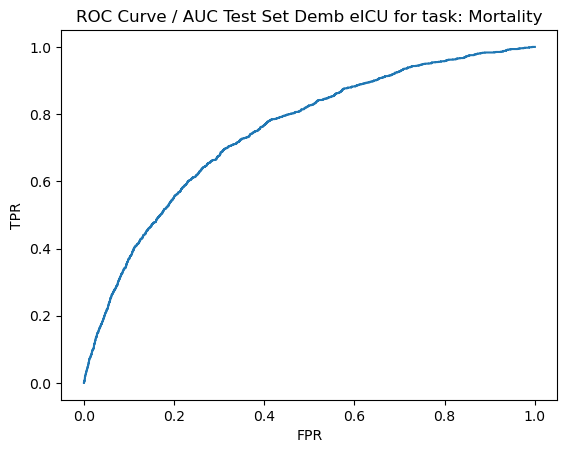

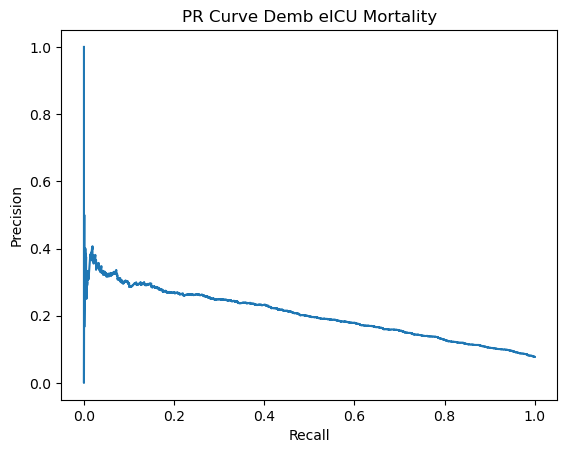

Test AUPRC:  0.2
test accuracy: 0.92


In [102]:
# One entry per epoch.
test_set_results = eicu_demb_mort_full_results[1]
PrintTrainTime(eicu_demb_mort_full_results[2])
PlotAucRecallResults(None, test_set_results[-1],
                     emb_type='Demb eICU', task_type='Mortality')
PrintFinalAccuracy(test_set_results)

### DescEmbFt - Mort - Full 

In [103]:
import importlib
import trainlib
import models
import datasets
importlib.reload(trainlib)
importlib.reload(models)
importlib.reload(datasets)
from trainlib import Trainer
from models import EHRModel, CembRNN, DembRNN
from datasets import SimpleDataset, DatasetCacher

args = DotArgs()
args.save_dir = os.path.join(os.getcwd(), 'modelcache')
if not os.path.exists(args.save_dir):
    os.mkdir(args.save_dir)
args.save_prefix = 'checkpoints'
args.random_seed = 90210
args.task = 'mort'
args.db_name = 'eicu'
args.is_dev = False  # if dev mode on we use a small subset of the full dataset.
assert(args.task in task_types)

# Model Args
# Load either a code_emb embed model or a desc_emb embed model.
args.eval_only = True
args.embed_model_type = 'desc_emb_ft'
args.predict_model_type = 'desc_emb_ft'
args.override_batch_size = BATCH_SIZE_
args.collate_fn = bert_fine_tune_collate
args.no_use_cached_dataset = eicu_mortality_dembft_dataset
args.embed_index_size = 0 # unused mort_demb_metadata['extra_data']['embed_index_size']=768
args.pred_embed_size = 0  # unused 


# Training Args
args.load_pretrained_weights = False
args.n_epochs = 10
args.learning_rate = 1.0e-4

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))
gc.collect()
del trainer
gc.collect()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
trainer = Trainer(args)
demb_ft_mort_full_model, _ = load_model_from_file('desc_emb_ft', 'mort', is_dev=False) 
trainer.model = demb_ft_mort_full_model
eicu_dembft_mort_full_results = trainer.train()

Total train time: 7e+01 s
Per epoch times: 7e+01


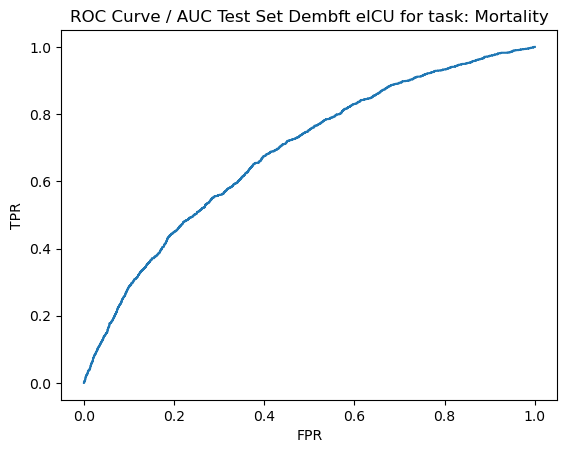

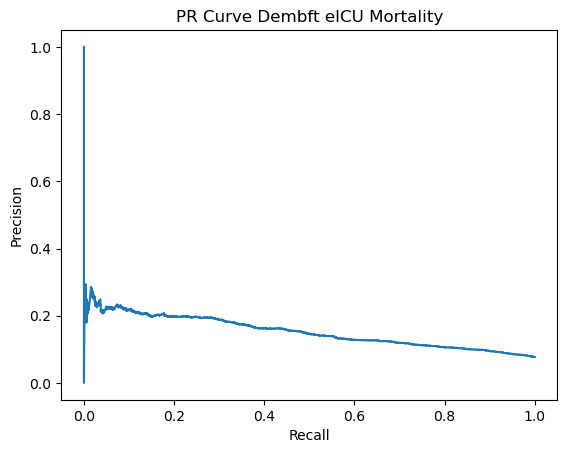

Test AUPRC:  0.15
test accuracy: 0.88


In [106]:
# One entry per epoch.
test_set_results = eicu_dembft_mort_full_results[1]
PrintTrainTime(eicu_dembft_mort_full_results[2])
PlotAucRecallResults(None, test_set_results[-1],
                     emb_type='Dembft eICU', task_type='Mortality')
PrintFinalAccuracy(test_set_results)